In [605]:
%matplotlib inline

In [606]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pickle
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

## Exploratory Data Analysis

In [607]:
cc_df = pd.read_csv('AnonymousBank/April1999.txt', sep='\t')

cc_df.head()

,vru+line,call_id,customer_id,priority,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server
0,AA0101,38080,0.0,0,PS,990401,20:06:04,20:06:14,10,0:00:00,0:00:00,0,AGENT,20:06:13,20:08:07,114,DORIT
1,AA0101,38081,50353564.0,2,PS,990401,20:22:17,20:22:22,5,20:22:22,20:23:58,96,AGENT,20:23:57,20:25:41,104,SHLOMO
2,AA0101,38082,13000567.0,2,PS,990401,20:41:53,20:41:58,5,20:41:58,20:42:55,57,AGENT,20:42:54,20:43:43,49,DORIT
3,AA0101,38083,50395060.0,1,PS,990401,21:31:04,21:31:11,7,21:31:11,21:31:31,20,AGENT,21:31:30,21:34:52,202,ZOHARI
4,AA0101,38084,0.0,0,PS,990401,21:58:51,21:59:01,10,0:00:00,0:00:00,0,AGENT,21:59:00,22:01:03,123,DORIT


In [608]:
# Check broken parsing
# Check if any 'type' values are not 2 characters long
# cc_df[cc_df['type'].str.len() != 2]

In [609]:
# Since these have 'HANG' outcome, let's just drop these rows
# cc_df = cc_df[cc_df['type'].str.len() == 2]

# cc_df[cc_df['type'].str.len() != 2]

In [610]:
# Change date column types to datetime
cc_df['date'] = pd.to_datetime(cc_df['date'], format='%y%m%d')

# Change time columns to datetime
cc_df['vru_entry'] = pd.to_datetime(cc_df['date'].astype(str) + ' ' + cc_df['vru_entry'], format='%Y-%m-%d %H:%M:%S')
cc_df['vru_exit'] = pd.to_datetime(cc_df['date'].astype(str) + ' ' + cc_df['vru_exit'], format='%Y-%m-%d %H:%M:%S')
cc_df['ser_start'] = pd.to_datetime(cc_df['date'].astype(str) + ' ' + cc_df['ser_start'], format='%Y-%m-%d %H:%M:%S')
cc_df['ser_exit'] = pd.to_datetime(cc_df['date'].astype(str) + ' ' + cc_df['ser_exit'], format='%Y-%m-%d %H:%M:%S')

# Change number columns to numeric
cc_df['vru_time'] = pd.to_numeric(cc_df['vru_time'], errors='coerce')
cc_df['q_time'] = pd.to_numeric(cc_df['q_time'], errors='coerce')
cc_df['ser_time'] = pd.to_numeric(cc_df['ser_time'], errors='coerce')

# Only keep rows with 'AGENT' in the 'outcome' column
cc_df = cc_df[cc_df['outcome'] == 'AGENT']

# Remove calls coming later than midnight and earlier than 7 AM
cc_df = cc_df[(cc_df['vru_entry'].dt.hour >= 7) & (cc_df['vru_entry'].dt.hour < 24)]

# Remove calls with 'NO_SERVER' server
cc_df = cc_df[cc_df['server'] != 'NO_SERVER']

# Drop unnecessary columns
cc_df = cc_df.drop(columns=['vru+line', 'customer_id', 'priority'])

# Display the first few rows of the cleaned DataFrame
cc_df.head()

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server
0,38080,PS,1999-04-01,1999-04-01 20:06:04,1999-04-01 20:06:14,10,0:00:00,0:00:00,0,AGENT,1999-04-01 20:06:13,1999-04-01 20:08:07,114,DORIT
1,38081,PS,1999-04-01,1999-04-01 20:22:17,1999-04-01 20:22:22,5,20:22:22,20:23:58,96,AGENT,1999-04-01 20:23:57,1999-04-01 20:25:41,104,SHLOMO
2,38082,PS,1999-04-01,1999-04-01 20:41:53,1999-04-01 20:41:58,5,20:41:58,20:42:55,57,AGENT,1999-04-01 20:42:54,1999-04-01 20:43:43,49,DORIT
3,38083,PS,1999-04-01,1999-04-01 21:31:04,1999-04-01 21:31:11,7,21:31:11,21:31:31,20,AGENT,1999-04-01 21:31:30,1999-04-01 21:34:52,202,ZOHARI
4,38084,PS,1999-04-01,1999-04-01 21:58:51,1999-04-01 21:59:01,10,0:00:00,0:00:00,0,AGENT,1999-04-01 21:59:00,1999-04-01 22:01:03,123,DORIT


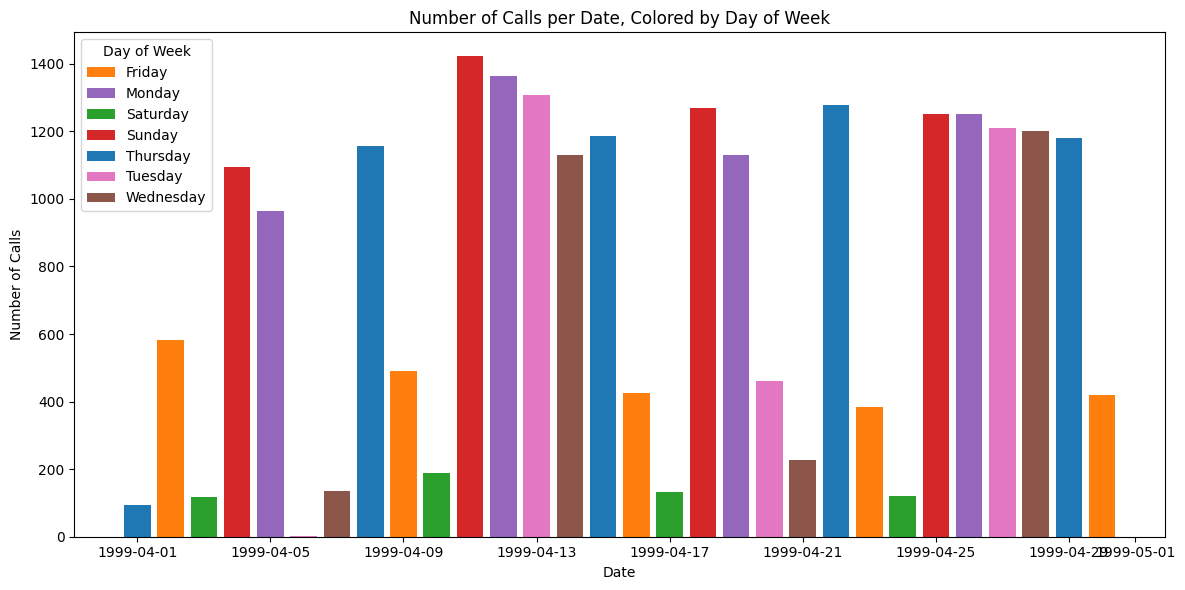

In [611]:
# Count the rows for each date

# Add day of week
cc_df['day_of_week'] = cc_df['date'].dt.day_name()
# Count the rows for each date and color by day of week
date_counts = cc_df.groupby(['date', 'day_of_week']).size().reset_index(name='count')
day_colors = dict(zip(cc_df['day_of_week'].unique(), sns.color_palette('tab10', n_colors=cc_df['day_of_week'].nunique())))
plt.figure(figsize=(12, 6))
for day, group in date_counts.groupby('day_of_week'):
    plt.bar(group['date'], group['count'], color=day_colors[day], label=day)
plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.title('Number of Calls per Date, Colored by Day of Week')
plt.legend(title='Day of Week')
plt.tight_layout()
plt.show()

In [612]:
# Lets analyse the one with highest number of calls, which is 1999-04-11
highest_calls_date = date_counts.loc[date_counts['count'].idxmax(), 'date']
highest_calls_df = cc_df[cc_df['date'] == highest_calls_date]

highest_calls_df

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week
308,38418,PS,1999-04-11,1999-04-11 07:20:08,1999-04-11 07:20:17,9,0:00:00,0:00:00,0,AGENT,1999-04-11 07:20:16,1999-04-11 07:32:38,742,GILI,Sunday
309,38419,PS,1999-04-11,1999-04-11 07:45:44,1999-04-11 07:45:50,6,7:45:50,7:46:26,36,AGENT,1999-04-11 07:46:25,1999-04-11 07:47:29,64,ROTH,Sunday
310,38420,NW,1999-04-11,1999-04-11 08:10:06,1999-04-11 08:10:19,13,0:00:00,0:00:00,0,AGENT,1999-04-11 08:10:17,1999-04-11 08:11:01,44,ROTH,Sunday
311,38421,PS,1999-04-11,1999-04-11 08:19:06,1999-04-11 08:19:15,9,0:00:00,0:00:00,0,AGENT,1999-04-11 08:19:15,1999-04-11 08:24:15,300,KAZAV,Sunday
312,38422,PS,1999-04-11,1999-04-11 08:31:06,1999-04-11 08:31:11,5,8:31:11,8:34:50,219,AGENT,1999-04-11 08:34:50,1999-04-11 08:44:46,596,AVIDAN,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31718,5993,NW,1999-04-11,1999-04-11 16:58:34,1999-04-11 16:58:43,9,16:58:43,17:06:43,480,AGENT,1999-04-11 17:06:42,1999-04-11 17:13:59,437,MORIAH,Sunday
31724,5999,PS,1999-04-11,1999-04-11 17:26:35,1999-04-11 17:26:41,6,17:26:41,17:28:42,121,AGENT,1999-04-11 17:28:40,1999-04-11 17:34:38,358,MIKI,Sunday
31727,6002,IN,1999-04-11,1999-04-11 17:50:00,1999-04-11 17:50:10,10,17:50:10,17:59:18,548,AGENT,1999-04-11 17:59:17,1999-04-11 18:02:15,178,YIFAT,Sunday
31728,6003,IN,1999-04-11,1999-04-11 18:12:18,1999-04-11 18:12:27,9,18:12:27,18:21:01,514,AGENT,1999-04-11 18:21:00,1999-04-11 18:26:14,314,BENSION,Sunday


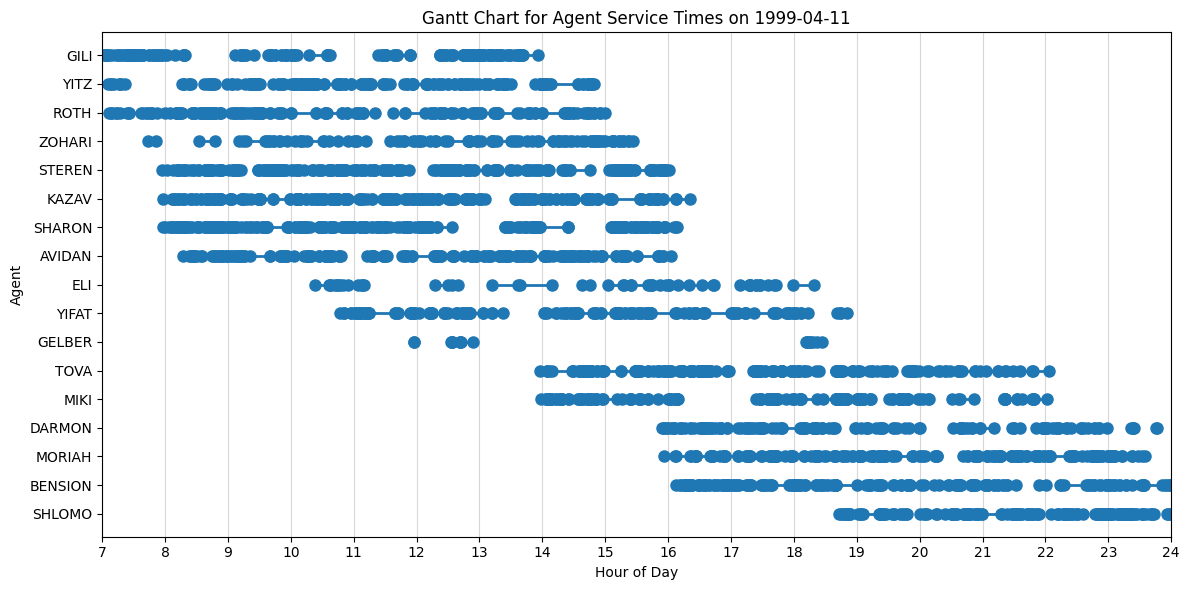

In [613]:
# Remove calls in service later than midnight and earlier than 7 AM
highest_calls_df = highest_calls_df[(highest_calls_df['ser_exit'].dt.hour >= 7) & (highest_calls_df['ser_exit'].dt.hour < 24)]

# Gantt chart for agents service times
# Assign a y position for each agent
agent_order = highest_calls_df['server'].unique()
# Sort agents by the first service start time
agent_order = highest_calls_df.groupby('server')['ser_start'].min().sort_values(ascending=False).index.to_numpy()
agent_to_y = {agent: i for i, agent in enumerate(agent_order)}

plt.figure(figsize=(12, 6))
for _, row in highest_calls_df.iterrows():
    y = agent_to_y[row['server']]
    x_start = row['ser_start'].hour + row['ser_start'].minute / 60 + row['ser_start'].second / 3600
    x_end = row['ser_exit'].hour + row['ser_exit'].minute / 60 + row['ser_exit'].second / 3600
    plt.hlines(y, x_start, x_end, color='tab:blue', linewidth=2)
    plt.plot([x_start, x_end], [y, y], 'o', color='tab:blue', markersize=8)  # blue dots

plt.xlabel('Hour of Day')
plt.ylabel('Agent')
plt.title(f'Gantt Chart for Agent Service Times on {highest_calls_date.date()}')
plt.xlim(7, 24)
plt.xticks(range(7, 25))
plt.yticks(range(len(agent_order)), agent_order)
plt.grid(True, axis='x', alpha=0.5)
plt.tight_layout()
plt.show()

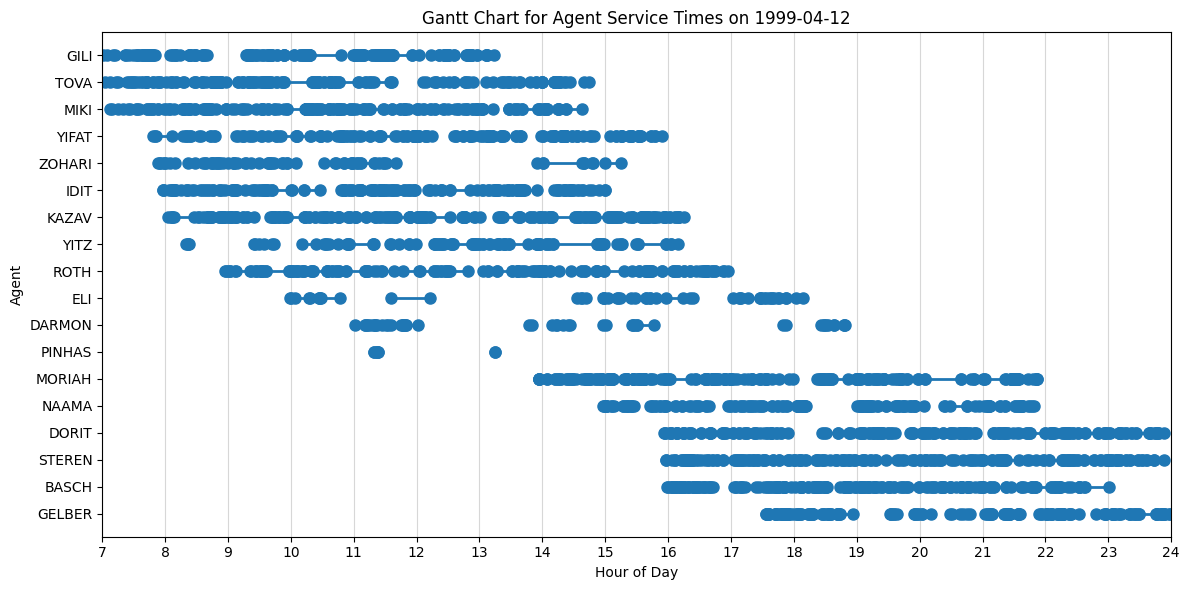

In [614]:
# Create gantt chart for the next day
next_day = highest_calls_date + pd.Timedelta(days=1)
next_day_df = cc_df[cc_df['date'] == next_day]

# Remove calls in service later than midnight and earlier than 7 AM
next_day_df = next_day_df[(next_day_df['ser_exit'].dt.hour >= 7) & (next_day_df['ser_exit'].dt.hour < 24)]

# Gantt chart for agents service times
# Assign a y position for each agent
agent_order_next = next_day_df['server'].unique()
agent_order_next = next_day_df.groupby('server')['ser_start'].min().sort_values(ascending=False).index.to_numpy()
agent_to_y_next = {agent: i for i, agent in enumerate(agent_order_next)}

plt.figure(figsize=(12, 6))
for _, row in next_day_df.iterrows():
    y = agent_to_y_next[row['server']]
    x_start = row['ser_start'].hour + row['ser_start'].minute / 60 + row['ser_start'].second / 3600
    x_end = row['ser_exit'].hour + row['ser_exit'].minute / 60 + row['ser_exit'].second / 3600
    plt.hlines(y, x_start, x_end, color='tab:blue', linewidth=2)
    plt.plot([x_start, x_end], [y, y], 'o', color='tab:blue', markersize=8)  # blue dots

plt.xlabel('Hour of Day')
plt.ylabel('Agent')
plt.title(f'Gantt Chart for Agent Service Times on {next_day.date()}')
plt.xlim(7, 24)
plt.xticks(range(7, 25))
plt.yticks(range(len(agent_order_next)), agent_order_next)
plt.grid(True, axis='x', alpha=0.5)
plt.tight_layout()
plt.show()

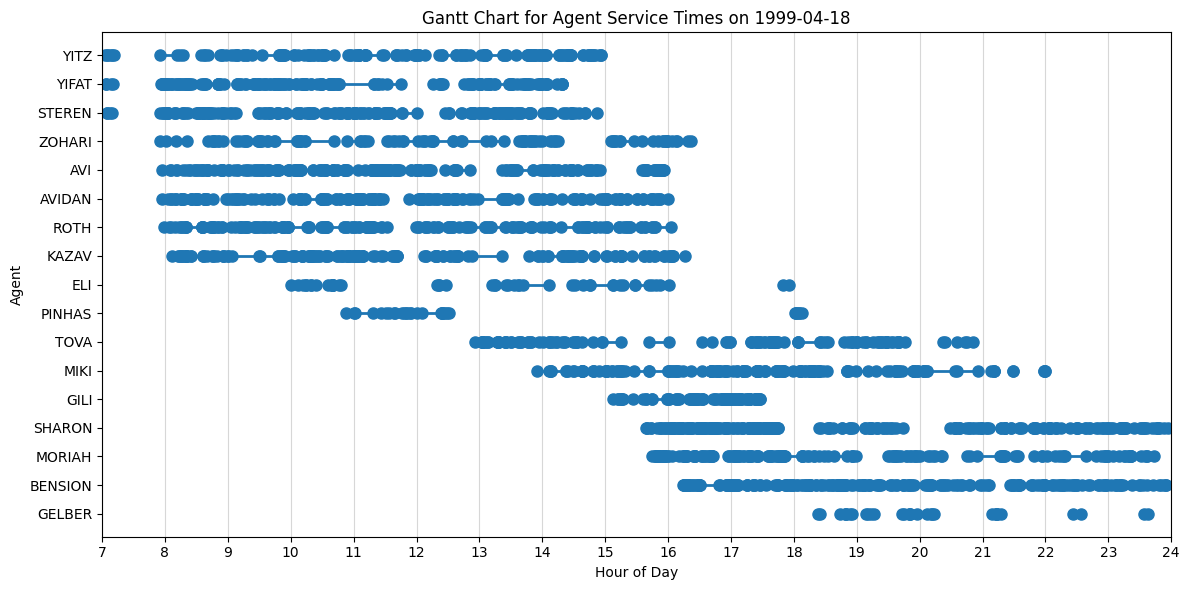

In [615]:
# Gantt chart for a week after the highest calls date
week_after_date = highest_calls_date + pd.Timedelta(days=7)
week_after_df = cc_df[(cc_df['date'] == week_after_date)]

# Remove calls in service later than midnight and earlier than 7 AM
week_after_df = week_after_df[(week_after_df['ser_exit'].dt.hour >= 7) & (week_after_df['ser_exit'].dt.hour < 24)]

# Gantt chart for agents service times
# Assign a y position for each agent
agent_order_week = week_after_df['server'].unique()
agent_order_week = week_after_df.groupby('server')['ser_start'].min().sort_values(ascending=False).index.to_numpy()
agent_to_y_week = {agent: i for i, agent in enumerate(agent_order_week)}

plt.figure(figsize=(12, 6))
for _, row in week_after_df.iterrows():
    y = agent_to_y_week[row['server']]
    x_start = row['ser_start'].hour + row['ser_start'].minute / 60 + row['ser_start'].second / 3600
    x_end = row['ser_exit'].hour + row['ser_exit'].minute / 60 + row['ser_exit'].second / 3600
    plt.hlines(y, x_start, x_end, color='tab:blue', linewidth=2)
    plt.plot([x_start, x_end], [y, y], 'o', color='tab:blue', markersize=8)  # blue dots

plt.xlabel('Hour of Day')
plt.ylabel('Agent')
plt.title(f'Gantt Chart for Agent Service Times on {week_after_date.date()}')
plt.xlim(7, 24)
plt.xticks(range(7, 25))
plt.yticks(range(len(agent_order_week)), agent_order_week)
plt.grid(True, axis='x', alpha=0.5)
plt.tight_layout()
plt.show()

### So different agents work at different times. But there are always 8 of them at one time

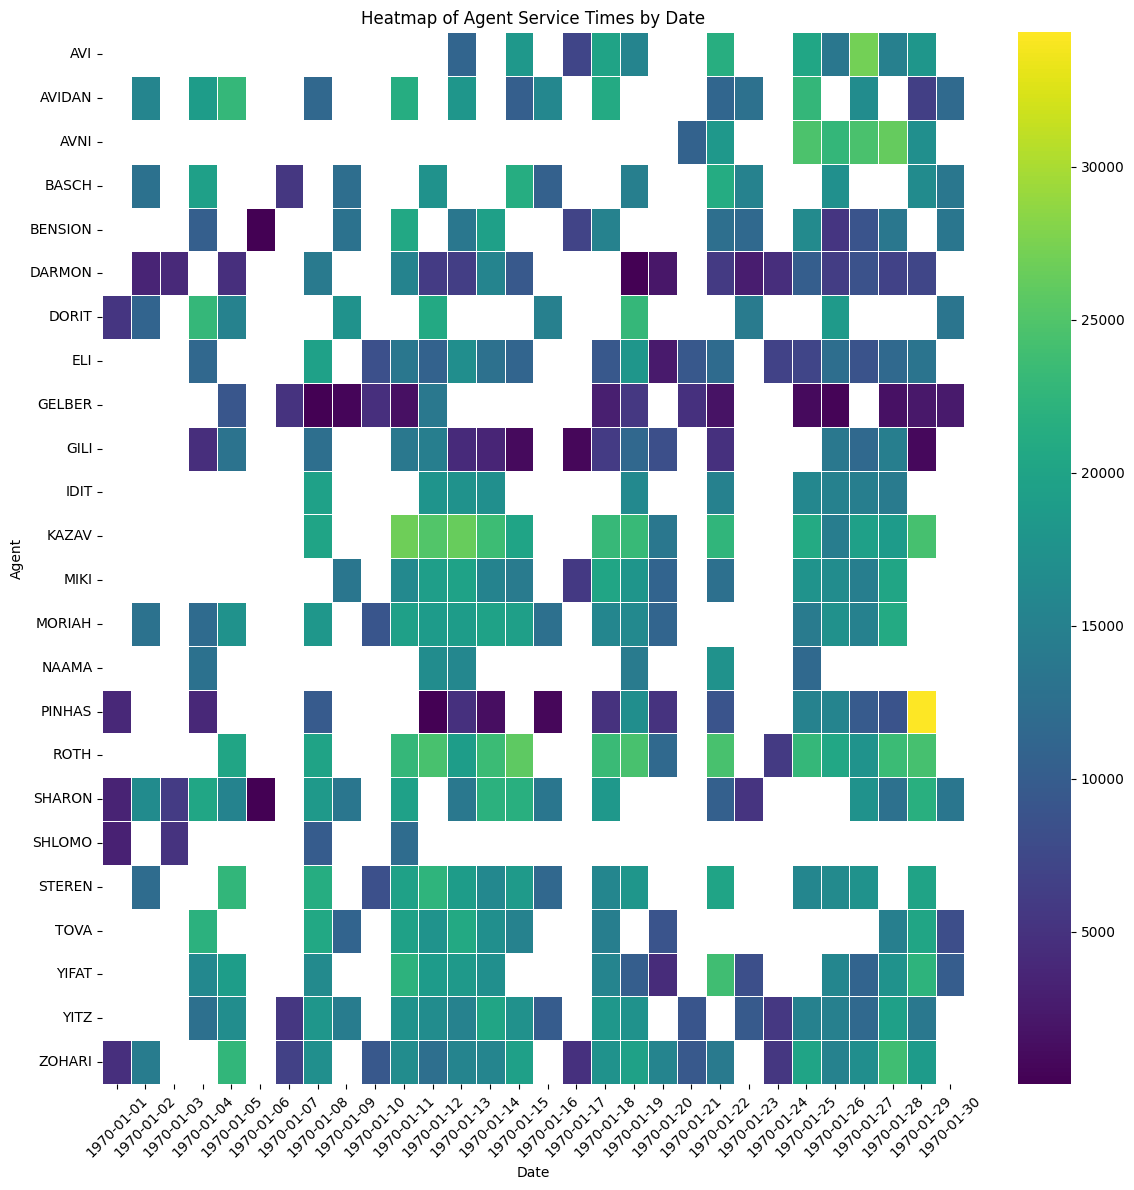

In [616]:
# Heatmap of agent service times each day
plt.figure(figsize=(12, 12))
# Create a pivot table for the heatmap
heatmap_data = cc_df.pivot_table(index='server', columns='date', values='ser_time', aggfunc='sum')
sns.heatmap(heatmap_data, cmap='viridis', annot=False, fmt='.1f', linewidths=.5)
plt.title('Heatmap of Agent Service Times by Date')
plt.xlabel('Date')
plt.ylabel('Agent')

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

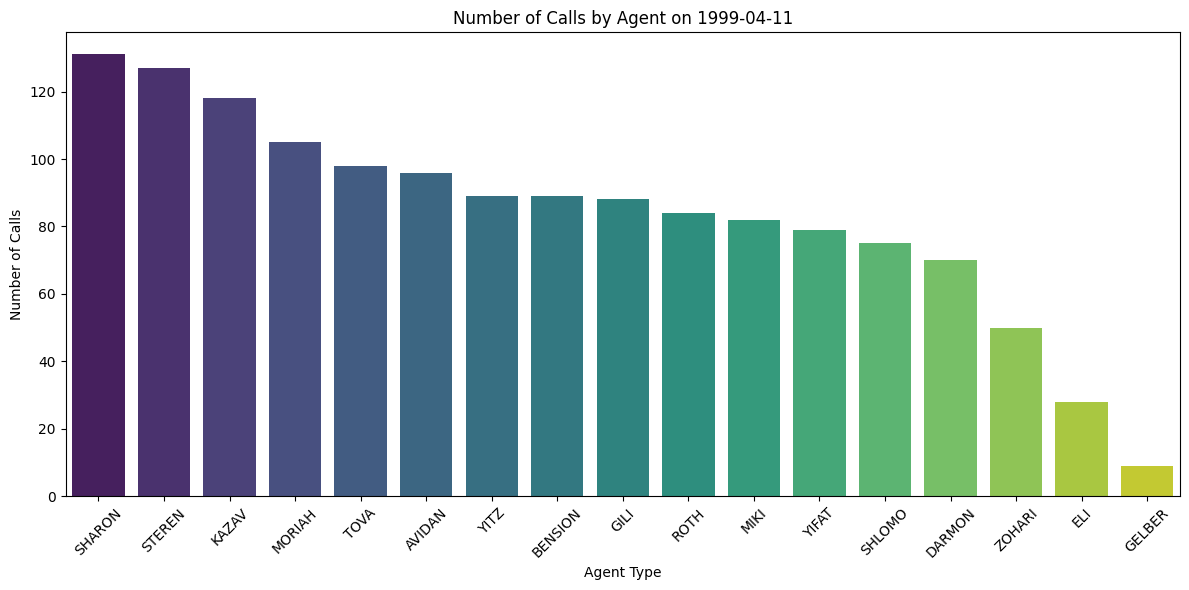

In [617]:
# Check the number of calls performed by each agent
agent_counts = highest_calls_df['server'].value_counts().reset_index()
agent_counts.columns = ['server', 'count']
plt.figure(figsize=(12, 6))
sns.barplot(x='server', y='count', data=agent_counts, palette='viridis', hue='server')
plt.xlabel('Agent Type')
plt.ylabel('Number of Calls')
plt.title(f'Number of Calls by Agent on {highest_calls_date.strftime("%Y-%m-%d")}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


No assignment pattern so we have to split manually or do clustering

### Let's split the call types into two types (simple and complex)

In [618]:
# Check rows with zero service time
cc_df[cc_df['ser_time'] == 0]

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week
603,38719,PS,1999-04-17,1999-04-17 23:46:18,1999-04-17 23:46:26,8,0:00:00,0:00:00,0,AGENT,1999-04-17 23:46:26,1999-04-17 23:46:26,0,MIKI,Saturday
1015,39145,PS,1999-04-28,1999-04-28 10:00:04,1999-04-28 10:00:10,6,10:00:10,10:01:04,54,AGENT,1999-04-28 00:00:00,1999-04-28 00:00:00,0,KAZAV,Wednesday
1016,39146,PS,1999-04-28,1999-04-28 10:10:03,1999-04-28 10:10:08,5,10:10:08,10:11:50,102,AGENT,1999-04-28 10:11:50,1999-04-28 10:11:50,0,MIKI,Wednesday
1455,34022,PS,1999-04-12,1999-04-12 09:20:44,1999-04-12 09:21:02,18,0:00:00,0:00:00,0,AGENT,1999-04-12 00:00:00,1999-04-12 00:00:00,0,MIKI,Monday
3819,26465,PS,1999-04-15,1999-04-15 17:14:06,1999-04-15 17:14:12,6,17:14:12,17:15:31,79,AGENT,1999-04-15 00:00:00,1999-04-15 00:00:00,0,ZOHARI,Thursday
3929,26579,PS,1999-04-19,1999-04-19 08:33:33,1999-04-19 08:33:38,5,8:33:38,8:33:44,6,AGENT,1999-04-19 08:33:43,1999-04-19 08:33:43,0,MIKI,Monday
4117,26776,PS,1999-04-25,1999-04-25 07:07:27,1999-04-25 07:07:36,9,0:00:00,0:00:00,0,AGENT,1999-04-25 00:00:00,1999-04-25 00:00:00,0,AVI,Sunday
4401,38537,NE,1999-04-04,1999-04-04 09:44:23,1999-04-04 09:44:32,9,0:00:00,0:00:00,0,AGENT,1999-04-04 00:00:00,1999-04-04 00:00:00,0,BASCH,Sunday
4989,39163,PS,1999-04-18,1999-04-18 21:09:51,1999-04-18 21:09:57,6,21:09:57,21:10:44,47,AGENT,1999-04-18 21:10:44,1999-04-18 21:10:44,0,MIKI,Sunday
5114,39291,PS,1999-04-22,1999-04-22 10:55:52,1999-04-22 10:55:59,7,10:55:59,10:59:52,233,AGENT,1999-04-22 10:59:52,1999-04-22 10:59:52,0,MIKI,Thursday


In [619]:
# Remove rows with zero service time
cc_df = cc_df[cc_df['ser_time'] > 0]

In [620]:
cc_df['ser_time'].describe()

count    23121.000000
mean       215.613166
std        347.202520
min          1.000000
25%         64.000000
50%        128.000000
75%        259.000000
max      30278.000000
Name: ser_time, dtype: float64

In [621]:
# Group the data by type and calculate the number of calls per type
cc_df_grouped = cc_df.groupby('type')

cc_df_grouped_count = cc_df_grouped.size().reset_index(name='count')
cc_df_grouped_count = cc_df_grouped_count.sort_values(by='count', ascending=False)

# Display the counts of each call type
cc_df_grouped_count

,type,count
4,PS,16970
2,NW,2431
1,NE,2415
5,TT,1031
0,IN,197
3,PE,77


In [622]:
# Display the first few rows of the grouped DataFrame
cc_df_grouped.head()

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week
0,38080,PS,1999-04-01,1999-04-01 20:06:04,1999-04-01 20:06:14,10,0:00:00,0:00:00,0,AGENT,1999-04-01 20:06:13,1999-04-01 20:08:07,114,DORIT,Thursday
1,38081,PS,1999-04-01,1999-04-01 20:22:17,1999-04-01 20:22:22,5,20:22:22,20:23:58,96,AGENT,1999-04-01 20:23:57,1999-04-01 20:25:41,104,SHLOMO,Thursday
2,38082,PS,1999-04-01,1999-04-01 20:41:53,1999-04-01 20:41:58,5,20:41:58,20:42:55,57,AGENT,1999-04-01 20:42:54,1999-04-01 20:43:43,49,DORIT,Thursday
3,38083,PS,1999-04-01,1999-04-01 21:31:04,1999-04-01 21:31:11,7,21:31:11,21:31:31,20,AGENT,1999-04-01 21:31:30,1999-04-01 21:34:52,202,ZOHARI,Thursday
4,38084,PS,1999-04-01,1999-04-01 21:58:51,1999-04-01 21:59:01,10,0:00:00,0:00:00,0,AGENT,1999-04-01 21:59:00,1999-04-01 22:01:03,123,DORIT,Thursday
12,38093,NW,1999-04-02,1999-04-02 09:03:23,1999-04-02 09:03:33,10,9:03:33,9:04:00,27,AGENT,1999-04-02 09:04:00,1999-04-02 09:04:35,35,SHARON,Friday
14,38095,NW,1999-04-02,1999-04-02 09:14:13,1999-04-02 09:14:22,9,9:14:22,9:15:50,88,AGENT,1999-04-02 09:15:49,1999-04-02 09:16:14,25,SHARON,Friday
29,38110,NW,1999-04-02,1999-04-02 12:24:43,1999-04-02 12:24:53,10,12:24:53,12:25:21,28,AGENT,1999-04-02 12:25:21,1999-04-02 12:25:59,38,BASCH,Friday
35,38116,NW,1999-04-02,1999-04-02 13:59:34,1999-04-02 13:59:48,14,0:00:00,0:00:00,0,AGENT,1999-04-02 13:59:47,1999-04-02 14:00:24,37,SHARON,Friday
53,38136,NW,1999-04-04,1999-04-04 07:56:02,1999-04-04 07:56:16,14,0:00:00,0:00:00,0,AGENT,1999-04-04 07:56:14,1999-04-04 07:56:27,13,SHARON,Sunday


Text(0.5, 1.0, 'Number of Calls per Type')

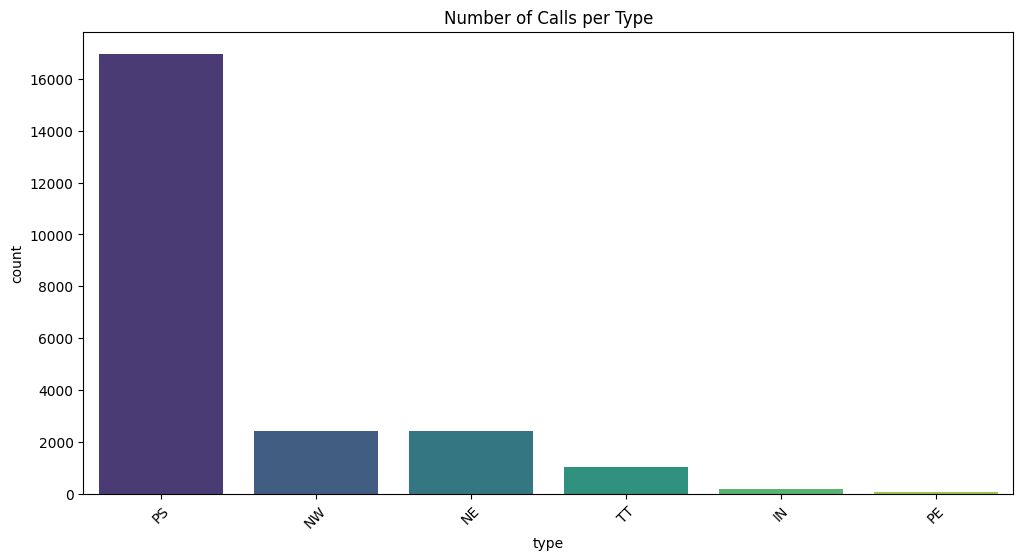

In [623]:
# Plot the number of calls per type
plt.figure(figsize=(12, 6))
sns.barplot(x='type', y='count', data=cc_df_grouped_count, palette='viridis', hue='type')
plt.xticks(rotation=45)
plt.title('Number of Calls per Type')

In [624]:
# Describe service times of each type dataframes
cc_df_grouped['ser_time'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
IN,197.0,334.086294,349.231807,2.0,102.0,206.0,404.0,2162.0
NE,2415.0,345.475362,419.651206,1.0,90.0,201.0,435.5,4327.0
NW,2431.0,110.016865,163.161833,1.0,35.0,59.0,121.0,3728.0
PE,77.0,258.753247,256.101396,1.0,96.0,191.0,342.0,1396.0
PS,16970.0,213.016559,266.948771,1.0,73.0,135.0,260.0,15576.0
TT,1031.0,177.291950,978.801415,1.0,14.5,62.0,167.5,30278.0


Since PS count is much bigger than the other, let's just split them into 'PS' and 'other', and define whichever faster to be simple call type

In [625]:
# Check the rows with the longest service times for each type
longest_service_times = cc_df.loc[cc_df_grouped['ser_time'].idxmax()]
longest_service_times

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week
31815,6090,IN,1999-04-15,1999-04-15 18:23:36,1999-04-15 18:23:46,10,18:23:46,18:29:55,369,AGENT,1999-04-15 18:29:54,1999-04-15 19:05:56,2162,YITZ,Thursday
8504,32911,NE,1999-04-08,1999-04-08 13:30:28,1999-04-08 13:30:34,6,13:30:34,13:33:35,181,AGENT,1999-04-08 13:33:35,1999-04-08 14:45:42,4327,ELI,Thursday
4613,38778,NW,1999-04-08,1999-04-08 22:05:45,1999-04-08 22:05:54,9,22:05:54,22:06:04,10,AGENT,1999-04-08 22:06:03,1999-04-08 23:08:11,3728,PINHAS,Thursday
12618,38034,PE,1999-04-12,1999-04-12 10:53:34,1999-04-12 10:53:38,4,10:53:38,10:55:16,98,AGENT,1999-04-12 10:55:15,1999-04-12 11:18:31,1396,YITZ,Monday
687,38805,PS,1999-04-19,1999-04-19 14:30:29,1999-04-19 14:30:34,5,14:30:34,14:33:49,195,AGENT,1999-04-19 14:33:48,1999-04-19 18:53:24,15576,PINHAS,Monday
9673,2958,TT,1999-04-29,1999-04-29 18:06:57,1999-04-29 18:06:59,2,0:00:00,0:00:00,0,AGENT,1999-04-29 09:45:21,1999-04-29 18:09:59,30278,PINHAS,Thursday


I think 8 hours of service is excessive, lets drop it

In [626]:
# Locate the top longest service time
longest_service_times = cc_df.loc[cc_df['ser_time'].idxmax()]

# Drop the call with the longest service time
cc_df = cc_df.drop(longest_service_times.name)

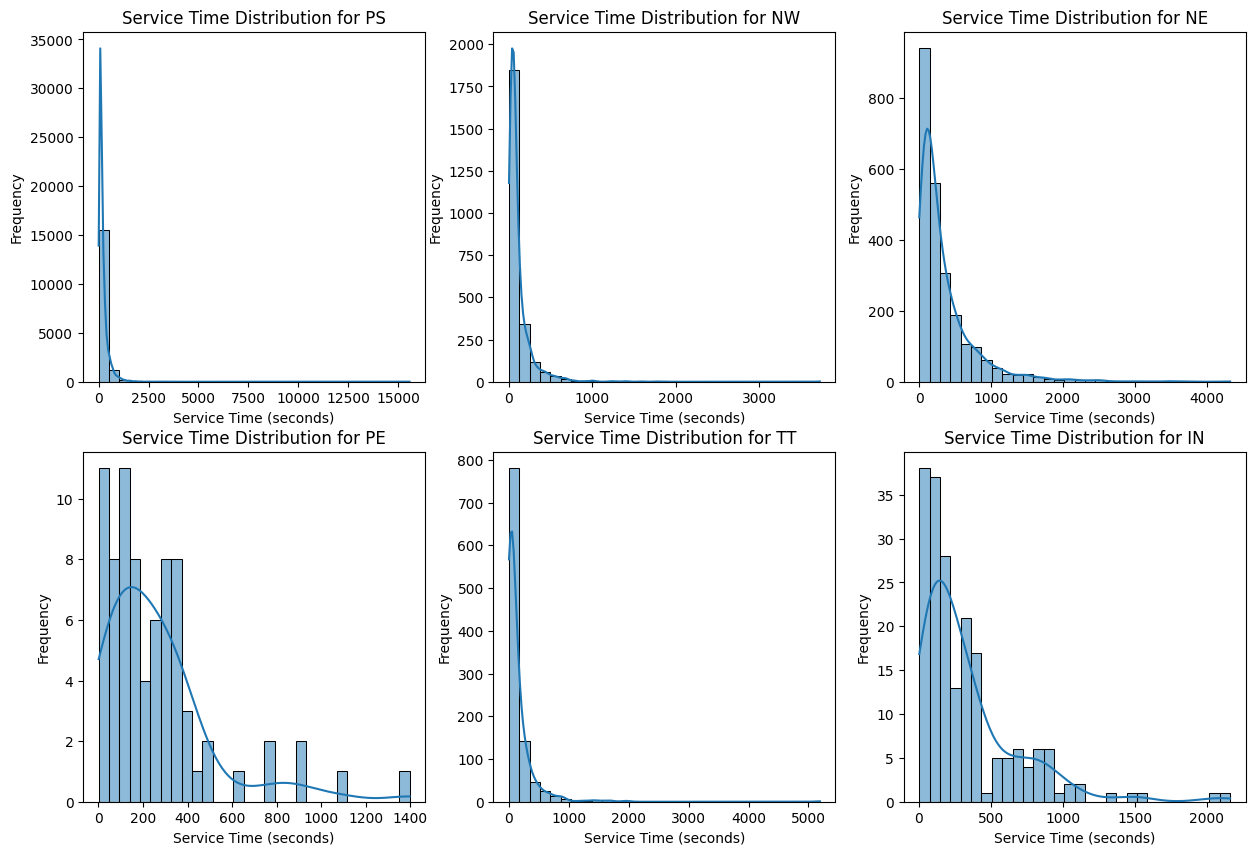

In [627]:
# Plot histogram of service times for each call type
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()
for i, call_type in enumerate(cc_df['type'].unique()):
    sns.histplot(cc_df[cc_df['type'] == call_type]['ser_time'], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Service Time Distribution for {call_type}')
    axes[i].set_xlabel('Service Time (seconds)')
    axes[i].set_ylabel('Frequency')

In [628]:
# QQ plot against exponential distribution
def qq_plot_exp(data, title):
    stats.probplot(data, dist="expon", plot=plt)
    plt.title(title)
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    
# QQ plot against lognormal distribution
def qq_plot_lognorm(data, title):
    shape, loc, scale = stats.lognorm.fit(data, floc=0)
    stats.probplot(data, dist="lognorm", sparams=(shape, loc, scale), plot=plt)
    plt.title(title)
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')

In [629]:
def ks_test_distributions_df(data):
    results = {}

    # Exponential: fit with data mean
    exp_params = (data.mean(),)
    d_exp, p_exp = stats.kstest(data, 'expon', args=exp_params)
    results['exponential'] = {'D-statistic': d_exp, 'p-value': p_exp}

    # Gamma: fit distribution to data
    gamma_params = stats.gamma.fit(data)
    d_gamma, p_gamma = stats.kstest(data, 'gamma', args=gamma_params)
    results['gamma'] = {'D-statistic': d_gamma, 'p-value': p_gamma}

    # Lognormal: fit distribution to data
    lognorm_params = stats.lognorm.fit(data)
    d_lognorm, p_lognorm = stats.kstest(data, 'lognorm', args=lognorm_params)
    results['lognormal'] = {'D-statistic': d_lognorm, 'p-value': p_lognorm}

    # Create DataFrame from results
    df = pd.DataFrame(results).T
    df['reject_null'] = df['p-value'] < 0.05

    # Find best fitting distribution
    best_fit = df['p-value'].idxmax()
    df['best_fit'] = best_fit
    return df


In [630]:
# Group the other call into one against 'PS'
cc_type_df = cc_df.copy()
cc_type_df['type_group'] = cc_type_df['type'].apply(lambda x: 'PS' if x == 'PS' else 'OTHERS')

# Display the first few rows of the grouped DataFrame
cc_type_df.head()

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,type_group
0,38080,PS,1999-04-01,1999-04-01 20:06:04,1999-04-01 20:06:14,10,0:00:00,0:00:00,0,AGENT,1999-04-01 20:06:13,1999-04-01 20:08:07,114,DORIT,Thursday,PS
1,38081,PS,1999-04-01,1999-04-01 20:22:17,1999-04-01 20:22:22,5,20:22:22,20:23:58,96,AGENT,1999-04-01 20:23:57,1999-04-01 20:25:41,104,SHLOMO,Thursday,PS
2,38082,PS,1999-04-01,1999-04-01 20:41:53,1999-04-01 20:41:58,5,20:41:58,20:42:55,57,AGENT,1999-04-01 20:42:54,1999-04-01 20:43:43,49,DORIT,Thursday,PS
3,38083,PS,1999-04-01,1999-04-01 21:31:04,1999-04-01 21:31:11,7,21:31:11,21:31:31,20,AGENT,1999-04-01 21:31:30,1999-04-01 21:34:52,202,ZOHARI,Thursday,PS
4,38084,PS,1999-04-01,1999-04-01 21:58:51,1999-04-01 21:59:01,10,0:00:00,0:00:00,0,AGENT,1999-04-01 21:59:00,1999-04-01 22:01:03,123,DORIT,Thursday,PS


In [631]:
cc_type_df_grouped = cc_type_df.groupby('type_group')

cc_type_df_grouped['ser_time'].describe()

,count,mean,std,min,25%,50%,75%,max
type_group,,,,,,,,
OTHERS,6150.0,217.889919,331.069675,1.0,42.0,100.5,254.0,5189.0
PS,16970.0,213.016559,266.948771,1.0,73.0,135.0,260.0,15576.0


### Now we need 2 agent groups from 15 agents. Lets see how each agent perform on simple and complex calls

### We will perform clustering to group them into two agent groups

In [451]:
# Calculate mean service time for each server and call type (SIMPLE, COMPLEX)
mean_ser_time = cc_type_df.groupby(['server', 'type_group'])['ser_time'].mean().unstack()
mean_ser_time = mean_ser_time.fillna(0)

mean_ser_time

type_group,COMPLEX,SIMPLE
server,,
ANAT,201.864253,194.834098
AVI,164.973684,129.253221
AVIDAN,211.525000,172.698582
AVNI,314.016949,226.016732
BASCH,201.783784,179.463010
BENSION,119.717742,119.698331
DARMON,287.500000,269.473029
DORIT,231.063492,211.704082
ELI,439.517520,294.041667


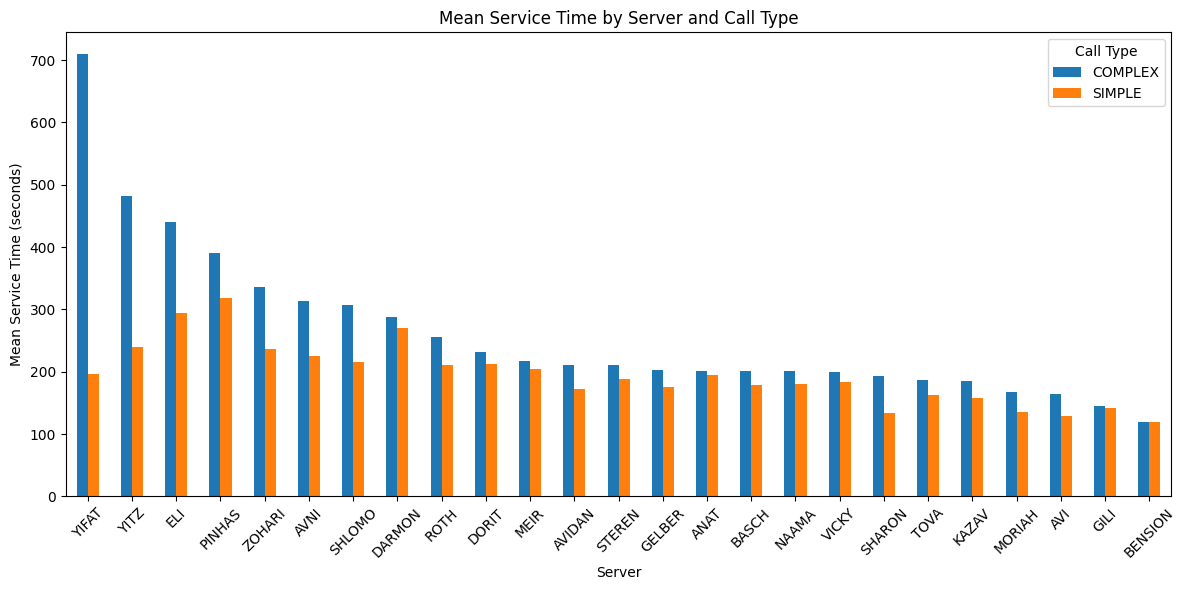

In [452]:
# Plot the mean service times for each server and call type
# Order by highest mean service time
mean_ser_time = mean_ser_time.sort_values(by='COMPLEX', ascending=False)
plt.figure(figsize=(12, 6))
mean_ser_time.plot(kind='bar', color=['#1f77b4', '#ff7f0e'], ax=plt.gca())
plt.xlabel('Server')
plt.ylabel('Mean Service Time (seconds)')
plt.title('Mean Service Time by Server and Call Type')
plt.legend(title='Call Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

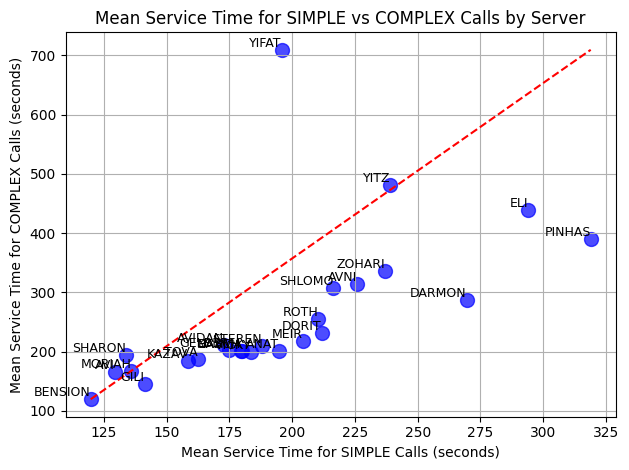

In [453]:
# Define the diagonal
simple_min = mean_ser_time['SIMPLE'].min()
simple_max = mean_ser_time['SIMPLE'].max()
complex_min = mean_ser_time['COMPLEX'].min()
complex_max = mean_ser_time['COMPLEX'].max()

# Create scatterplot of mean service times for each server and call type
plt.figure(figsize=(12, 6))
mean_ser_time.plot(kind='scatter', x='SIMPLE', y='COMPLEX', color='blue', s=100, alpha=0.7)
plt.xlabel('Mean Service Time for SIMPLE Calls (seconds)')
plt.ylabel('Mean Service Time for COMPLEX Calls (seconds)')
plt.title('Mean Service Time for SIMPLE vs COMPLEX Calls by Server')
# Add middle line (y = x)
plt.plot([simple_min, simple_max],
         [complex_min, complex_max],
         'r--', label='Mean service time')

# Label the dots with server names
for server, row in mean_ser_time.iterrows():
    plt.text(row['SIMPLE'], row['COMPLEX'], server, fontsize=9, ha='right', va='bottom')

# plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [454]:
# Slope and intercept of the diagonal
m = (complex_max - complex_min) / (simple_max - simple_min)
c = complex_min - m * simple_min

# Calculate the y-value on the diagonal for each server's SIMPLE mean
diagonal_y = m * mean_ser_time['SIMPLE'] + c

# Find servers above and under the line
servers_above = mean_ser_time[mean_ser_time['COMPLEX'] > diagonal_y]
servers_under = mean_ser_time[mean_ser_time['COMPLEX'] < diagonal_y]

print("Servers ABOVE the plotted line:")
print(servers_above[['SIMPLE', 'COMPLEX']])

print("\nServers UNDER the plotted line:")
print(servers_under[['SIMPLE', 'COMPLEX']])

Servers ABOVE the plotted line:
type_group      SIMPLE     COMPLEX
server                            
YIFAT       195.783046  709.197368
YITZ        239.047564  481.468966
SHARON      133.853551  193.588889
MORIAH      135.844530  168.140673
AVI         129.253221  164.973684

Servers UNDER the plotted line:
type_group      SIMPLE     COMPLEX
server                            
ELI         294.041667  439.517520
PINHAS      318.945545  390.166667
ZOHARI      236.955738  336.728997
AVNI        226.016732  314.016949
SHLOMO      216.261261  306.555556
DARMON      269.473029  287.500000
ROTH        210.349198  255.083333
DORIT       211.704082  231.063492
MEIR        204.323232  217.892857
AVIDAN      172.698582  211.525000
STEREN      187.932647  210.198758
GELBER      174.989446  202.000000
ANAT        194.834098  201.864253
BASCH       179.463010  201.783784
NAAMA       180.107191  201.603604
VICKY       183.639676  199.227778
TOVA        162.308658  187.162602
KAZAV       158.307278  1

In [455]:
# Group the servers into two groups based on their position relative to the diagonal
mean_ser_time['group'] = np.where(mean_ser_time['COMPLEX'] > diagonal_y, '1', '2')

# Check the grouped means
grouped_means = (
    mean_ser_time.groupby('group')[['SIMPLE', 'COMPLEX']].mean()
)

print(grouped_means)

type_group      SIMPLE     COMPLEX
group                             
1           166.756382  343.473916
2           202.161648  242.164357


In [456]:
mean_ser_time

type_group,COMPLEX,SIMPLE,group
server,,,
YIFAT,709.197368,195.783046,1
YITZ,481.468966,239.047564,1
ELI,439.517520,294.041667,2
PINHAS,390.166667,318.945545,2
ZOHARI,336.728997,236.955738,2
AVNI,314.016949,226.016732,2
SHLOMO,306.555556,216.261261,2
DARMON,287.500000,269.473029,2
ROTH,255.083333,210.349198,2


In [457]:
# Apply the grouping to the main dataframe
cc_type_df['group'] = np.where(cc_type_df['server'].isin(servers_above.index), '1', '2')

cc_type_df

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,type_group,group
2,41888,PS,1999-07-01,1999-07-01 07:30:27,1999-07-01 07:30:35,8,0:00:00,0:00:00,0,AGENT,1999-07-01 07:30:35,1999-07-01 07:34:16,221,MORIAH,Thursday,SIMPLE,1
3,41889,PS,1999-07-01,1999-07-01 07:49:32,1999-07-01 07:49:37,5,7:49:37,7:50:27,50,AGENT,1999-07-01 07:50:26,1999-07-01 07:51:48,82,ANAT,Thursday,SIMPLE,2
4,41890,PS,1999-07-01,1999-07-01 08:03:56,1999-07-01 08:04:08,12,0:00:00,0:00:00,0,AGENT,1999-07-01 08:04:07,1999-07-01 08:05:25,78,KAZAV,Thursday,SIMPLE,2
5,41891,PS,1999-07-01,1999-07-01 08:22:12,1999-07-01 08:22:25,13,0:00:00,0:00:00,0,AGENT,1999-07-01 08:22:24,1999-07-01 08:32:12,588,YIFAT,Thursday,SIMPLE,1
6,41892,PS,1999-07-01,1999-07-01 08:32:24,1999-07-01 08:32:29,5,8:32:29,8:32:45,16,AGENT,1999-07-01 08:32:44,1999-07-01 08:33:39,55,TOVA,Thursday,SIMPLE,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39010,7886,IN,1999-07-30,1999-07-30 12:46:50,1999-07-30 12:46:59,9,12:46:59,12:48:28,89,AGENT,1999-07-30 12:48:27,1999-07-30 12:49:47,80,BENSION,Friday,COMPLEX,2
39011,7887,IN,1999-07-30,1999-07-30 13:01:19,1999-07-30 13:01:38,19,0:00:00,0:00:00,0,AGENT,1999-07-30 13:01:37,1999-07-30 13:15:12,815,BENSION,Friday,COMPLEX,2
39012,7888,IN,1999-07-30,1999-07-30 13:30:21,1999-07-30 13:30:36,15,0:00:00,0:00:00,0,AGENT,1999-07-30 13:30:35,1999-07-30 13:32:58,143,SHARON,Friday,COMPLEX,1
39019,7895,IN,1999-07-31,1999-07-31 22:09:48,1999-07-31 22:10:07,19,0:00:00,0:00:00,0,AGENT,1999-07-31 22:10:06,1999-07-31 22:11:46,100,AVI,Saturday,COMPLEX,1


In [458]:
# Calculate daily average and variance for each group
grouped_daily = cc_type_df.groupby(['date', 'group'])['ser_time'].agg(['mean', 'var']).reset_index()

mean_pivot = grouped_daily.pivot(index='date', columns='group', values='mean')
var_pivot = grouped_daily.pivot(index='date', columns='group', values='var')

mean_pivot, var_pivot

(group                1           2
 date                              
 1999-07-01  171.720971  190.405550
 1999-07-02  150.153285  179.669439
 1999-07-03  113.328767  254.595745
 1999-07-04  141.757534  183.709154
 1999-07-05  156.432258  204.698779
 1999-07-06  165.683570  201.285538
 1999-07-07  172.226891  202.377027
 1999-07-08  170.582397  203.536290
 1999-07-09  152.288288  182.011321
 1999-07-10  121.531915  302.674419
 1999-07-11  130.703046  196.546092
 1999-07-12  178.522936  207.111111
 1999-07-13  206.381323  194.895537
 1999-07-14  153.412921  188.234783
 1999-07-15  217.353933  212.925029
 1999-07-16         NaN  187.018405
 1999-07-17  291.750000  228.660377
 1999-07-18  167.159091  201.342581
 1999-07-19  159.939954  215.650062
 1999-07-20  137.969388  191.744498
 1999-07-21  142.441379  219.217978
 1999-07-22   93.184211  134.927765
 1999-07-23  182.781513  204.969027
 1999-07-24  154.666667  167.500000
 1999-07-25  170.740230  206.969448
 1999-07-26  178.865229  207

In [459]:
# Check records from 16 July that broke the calculations
cc_type_df[(cc_type_df['group'] == 1) & (cc_type_df['date'] == '1999-07-16')]['ser_time']

Series([], Name: ser_time, dtype: int64)

In [460]:
cc_type_df.loc[cc_type_df['date'] == '1999-07-16', ['ser_time', 'group']]

,ser_time,group
901,98,2
902,63,2
903,146,2
904,75,2
905,616,2
...,...,...
15346,31,2
15347,155,2
15348,1,2
15349,81,2


Apparently there were no one from group 1 working on July 16th

In [461]:
cc_type_df[cc_type_df['group'] == '1']['ser_time'].count(), cc_type_df[cc_type_df['group'] == '2']['ser_time'].count()

(np.int64(9515), np.int64(19531))

So the count of group 1 is much smaller, less than half of group 2

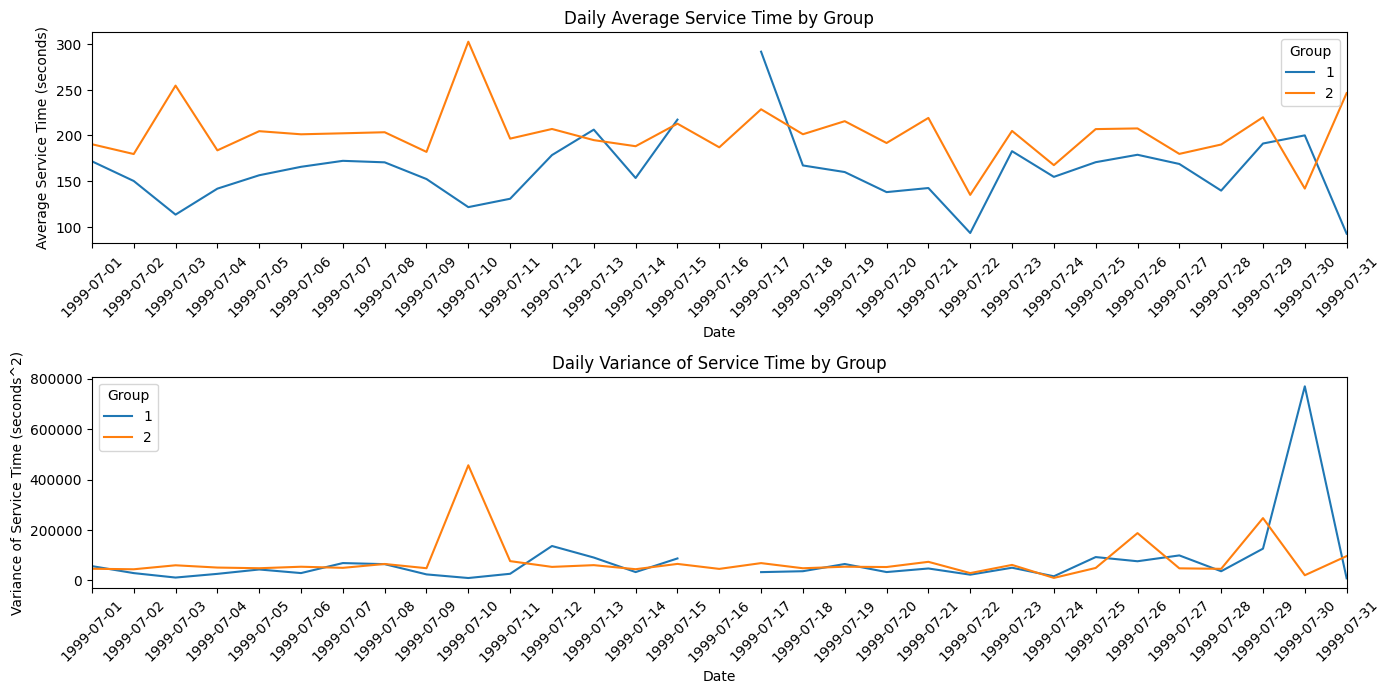

In [462]:
# Plot the average and variance as time series
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
ax1 = plt.gca()
mean_pivot.plot(ax=ax1)
plt.title('Daily Average Service Time by Group')
plt.xlabel('Date')
plt.ylabel('Average Service Time (seconds)')
plt.legend(title='Group')
# Force all dates to appear as x-ticks
ax1.set_xticks(mean_pivot.index)
ax1.set_xticklabels([date.strftime('%Y-%m-%d') for date in mean_pivot.index], rotation=45)

plt.subplot(2, 1, 2)
ax2 = plt.gca()
var_pivot.plot(ax=ax2)
plt.title('Daily Variance of Service Time by Group')
plt.xlabel('Date')
plt.ylabel('Variance of Service Time (seconds^2)')
plt.legend(title='Group')
plt.tight_layout()
# Force all dates to appear as x-ticks
ax2.set_xticks(var_pivot.index)
ax2.set_xticklabels([date.strftime('%Y-%m-%d') for date in var_pivot.index], rotation=45)

plt.show()

Let's shift our line a bit to make it more equal, by 12.5% of the mean

<Figure size 1200x600 with 0 Axes>

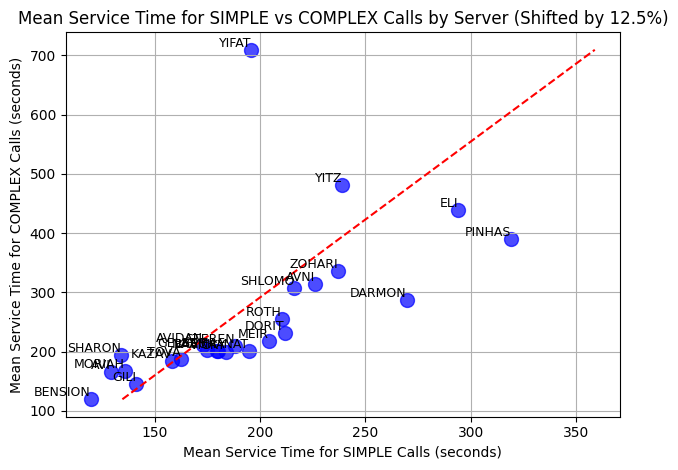

In [463]:
# Create scatterplot of mean service times for each server and call type
plt.figure(figsize=(12, 6))
mean_ser_time.plot(kind='scatter', x='SIMPLE', y='COMPLEX', color='blue', s=100, alpha=0.7)
plt.xlabel('Mean Service Time for SIMPLE Calls (seconds)')
plt.ylabel('Mean Service Time for COMPLEX Calls (seconds)')
plt.title('Mean Service Time for SIMPLE vs COMPLEX Calls by Server (Shifted by 12.5%)')
# Add middle line (y = x)
plt.plot([simple_min + (simple_min * 0.125), simple_max + (simple_max * 0.125)],
         [complex_min, complex_max],
         'r--', label='Mean service time')

# Label the dots with server names
for server, row in mean_ser_time.iterrows():
    plt.text(row['SIMPLE'], row['COMPLEX'], server, fontsize=9, ha='right', va='bottom')

# plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [464]:
# Compute shifted line endpoints
simple_min_shifted = simple_min + (simple_min * 0.125)
simple_max_shifted = simple_max + (simple_max * 0.125)

# Slope and intercept of the moved diagonal
m = (complex_max - complex_min) / (simple_max_shifted - simple_min_shifted)
c = complex_min - m * simple_min_shifted

# Calculate the y-value on the moved diagonal for each server's SIMPLE mean
diagonal_y = m * mean_ser_time['SIMPLE'] + c

# Find servers above and under the moved diagonal line
servers_above = mean_ser_time[mean_ser_time['COMPLEX'] > diagonal_y]
servers_under = mean_ser_time[mean_ser_time['COMPLEX'] < diagonal_y]

print("Servers count per group:")
print(servers_above.shape[0], "servers above the shifted line")
print(servers_under.shape[0], "servers under the shifted line")

print("Servers ABOVE the shifted line:")
print(servers_above[['SIMPLE', 'COMPLEX']])

print("\nServers UNDER the shifted line:")
print(servers_under[['SIMPLE', 'COMPLEX']])

Servers count per group:
8 servers above the shifted line
17 servers under the shifted line
Servers ABOVE the shifted line:
type_group      SIMPLE     COMPLEX
server                            
YIFAT       195.783046  709.197368
YITZ        239.047564  481.468966
SHARON      133.853551  193.588889
KAZAV       158.307278  184.620553
MORIAH      135.844530  168.140673
AVI         129.253221  164.973684
GILI        141.183562  145.057692
BENSION     119.698331  119.717742

Servers UNDER the shifted line:
type_group      SIMPLE     COMPLEX
server                            
ELI         294.041667  439.517520
PINHAS      318.945545  390.166667
ZOHARI      236.955738  336.728997
AVNI        226.016732  314.016949
SHLOMO      216.261261  306.555556
DARMON      269.473029  287.500000
ROTH        210.349198  255.083333
DORIT       211.704082  231.063492
MEIR        204.323232  217.892857
AVIDAN      172.698582  211.525000
STEREN      187.932647  210.198758
GELBER      174.989446  202.000000
ANA

In [465]:
# Group the servers into two groups based on their position relative to the diagonal
mean_ser_time['group_2'] = np.where(mean_ser_time['COMPLEX'] > diagonal_y, '1', '2')

# Check the grouped means
grouped_means = (
    mean_ser_time.groupby('group_2')[['SIMPLE', 'COMPLEX']].mean()
)

print(grouped_means)

type_group      SIMPLE     COMPLEX
group_2                           
1           156.621385  270.845696
2           213.179047  258.464185


In [466]:
# Apply second grouping to the main dataframe
cc_type_df['group_2'] = np.where(cc_type_df['server'].isin(servers_above.index), '1', '2')

cc_type_df

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,type_group,group,group_2
2,41888,PS,1999-07-01,1999-07-01 07:30:27,1999-07-01 07:30:35,8,0:00:00,0:00:00,0,AGENT,1999-07-01 07:30:35,1999-07-01 07:34:16,221,MORIAH,Thursday,SIMPLE,1,1
3,41889,PS,1999-07-01,1999-07-01 07:49:32,1999-07-01 07:49:37,5,7:49:37,7:50:27,50,AGENT,1999-07-01 07:50:26,1999-07-01 07:51:48,82,ANAT,Thursday,SIMPLE,2,2
4,41890,PS,1999-07-01,1999-07-01 08:03:56,1999-07-01 08:04:08,12,0:00:00,0:00:00,0,AGENT,1999-07-01 08:04:07,1999-07-01 08:05:25,78,KAZAV,Thursday,SIMPLE,2,1
5,41891,PS,1999-07-01,1999-07-01 08:22:12,1999-07-01 08:22:25,13,0:00:00,0:00:00,0,AGENT,1999-07-01 08:22:24,1999-07-01 08:32:12,588,YIFAT,Thursday,SIMPLE,1,1
6,41892,PS,1999-07-01,1999-07-01 08:32:24,1999-07-01 08:32:29,5,8:32:29,8:32:45,16,AGENT,1999-07-01 08:32:44,1999-07-01 08:33:39,55,TOVA,Thursday,SIMPLE,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39010,7886,IN,1999-07-30,1999-07-30 12:46:50,1999-07-30 12:46:59,9,12:46:59,12:48:28,89,AGENT,1999-07-30 12:48:27,1999-07-30 12:49:47,80,BENSION,Friday,COMPLEX,2,1
39011,7887,IN,1999-07-30,1999-07-30 13:01:19,1999-07-30 13:01:38,19,0:00:00,0:00:00,0,AGENT,1999-07-30 13:01:37,1999-07-30 13:15:12,815,BENSION,Friday,COMPLEX,2,1
39012,7888,IN,1999-07-30,1999-07-30 13:30:21,1999-07-30 13:30:36,15,0:00:00,0:00:00,0,AGENT,1999-07-30 13:30:35,1999-07-30 13:32:58,143,SHARON,Friday,COMPLEX,1,1
39019,7895,IN,1999-07-31,1999-07-31 22:09:48,1999-07-31 22:10:07,19,0:00:00,0:00:00,0,AGENT,1999-07-31 22:10:06,1999-07-31 22:11:46,100,AVI,Saturday,COMPLEX,1,1


In [467]:
# Check the number of calls performed by each group
cc_type_df[cc_type_df['group_2'] == '1']['ser_time'].count(), cc_type_df[cc_type_df['group_2'] == '2']['ser_time'].count()

(np.int64(13351), np.int64(15695))

So this grouping looks better.
* The difference of server number per group is smaller
* The service time for each group and each call type still follow the rule, although the difference between complex call service time is small
* Call count split almost evenly

In [468]:
# Calculate daily average and variance for each group
grouped_daily = cc_type_df.groupby(['date', 'group_2'])['ser_time'].agg(['mean', 'var']).reset_index()

mean_pivot = grouped_daily.pivot(index='date', columns='group_2', values='mean')
var_pivot = grouped_daily.pivot(index='date', columns='group_2', values='var')

mean_pivot, var_pivot

(group_2              1           2
 date                              
 1999-07-01  167.239538  196.828258
 1999-07-02  148.543716  188.164524
 1999-07-03  113.328767  254.595745
 1999-07-04  146.307190  201.779693
 1999-07-05  161.664083  210.502573
 1999-07-06  164.446602  208.909357
 1999-07-07  169.502196  217.577861
 1999-07-08  168.790732  212.809524
 1999-07-09  142.757862  216.828402
 1999-07-10  121.531915  302.674419
 1999-07-11  131.482507  223.021246
 1999-07-12  176.725118  216.619382
 1999-07-13  171.915683  218.018131
 1999-07-14  150.236334  205.418960
 1999-07-15  203.784387  217.109536
 1999-07-16  104.061728  214.444898
 1999-07-17  291.750000  228.660377
 1999-07-18  155.952294  221.319182
 1999-07-19  160.020408  224.060258
 1999-07-20  128.909091  219.288360
 1999-07-21  135.430622  235.960630
 1999-07-22   93.184211  134.927765
 1999-07-23  170.848341  238.992537
 1999-07-24  154.666667  167.500000
 1999-07-25  156.169091  223.519022
 1999-07-26  178.865229  207

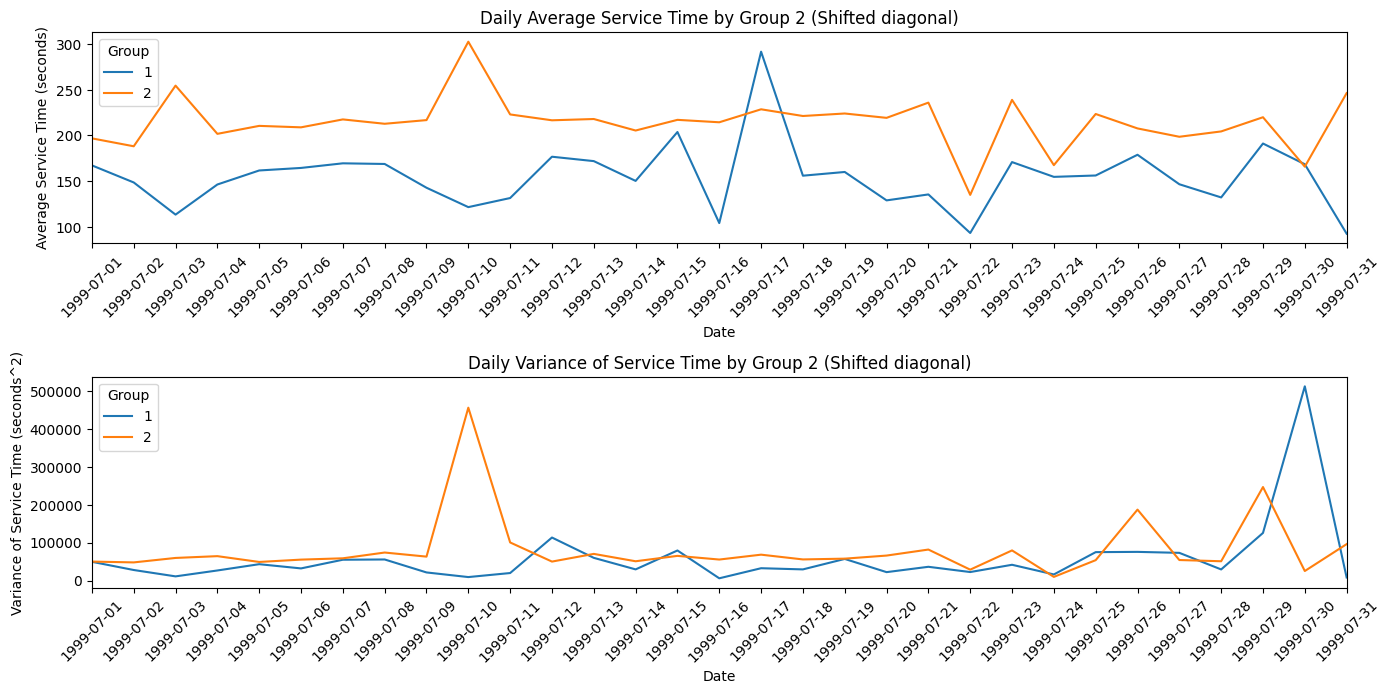

In [469]:
# Plot the average and variance as time series
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
ax1 = plt.gca()
mean_pivot.plot(ax=ax1)
plt.title('Daily Average Service Time by Group 2 (Shifted diagonal)')
plt.xlabel('Date')
plt.ylabel('Average Service Time (seconds)')
plt.legend(title='Group')
# Force all dates to appear as x-ticks
ax1.set_xticks(mean_pivot.index)
ax1.set_xticklabels([date.strftime('%Y-%m-%d') for date in mean_pivot.index], rotation=45)

plt.subplot(2, 1, 2)
ax2 = plt.gca()
var_pivot.plot(ax=ax2)
plt.title('Daily Variance of Service Time by Group 2 (Shifted diagonal)')
plt.xlabel('Date')
plt.ylabel('Variance of Service Time (seconds^2)')
plt.legend(title='Group')
plt.tight_layout()
# Force all dates to appear as x-ticks
ax2.set_xticks(var_pivot.index)
ax2.set_xticklabels([date.strftime('%Y-%m-%d') for date in var_pivot.index], rotation=45)

plt.show()

### Let's try performing Ward's clustering

In [470]:
scaler = StandardScaler()
X = scaler.fit_transform(mean_ser_time[['SIMPLE', 'COMPLEX']])

clustering = AgglomerativeClustering(n_clusters=2, linkage='ward')
mean_ser_time['cluster'] = clustering.fit_predict(X)

mean_ser_time

type_group,COMPLEX,SIMPLE,group,group_2,cluster
server,,,,,
YIFAT,709.197368,195.783046,1,1,0
YITZ,481.468966,239.047564,1,1,0
ELI,439.517520,294.041667,2,2,0
PINHAS,390.166667,318.945545,2,2,0
ZOHARI,336.728997,236.955738,2,2,0
AVNI,314.016949,226.016732,2,2,0
SHLOMO,306.555556,216.261261,2,2,0
DARMON,287.500000,269.473029,2,2,0
ROTH,255.083333,210.349198,2,2,1


In [471]:
# Check the average service time for each cluster
mean_ser_time.groupby('cluster')[['SIMPLE', 'COMPLEX']].mean()

type_group,SIMPLE,COMPLEX
cluster,,
0,249.565573,408.144003
1,169.440605,193.853217


In [472]:
# Apply the grouping to the main dataframe
cc_type_df['cluster'] = np.where(cc_type_df['server'].isin(mean_ser_time[mean_ser_time['cluster'] == 0].index), '0', '1')

# Check the number of calls performed by each group
cc_type_df[cc_type_df['cluster'] == '0']['ser_time'].count(), cc_type_df[cc_type_df['cluster'] == '1']['ser_time'].count()

(np.int64(6104), np.int64(22942))

In [473]:
# Calculate daily average and variance for each group
grouped_daily = cc_type_df.groupby(['date', 'cluster'])['ser_time'].agg(['mean', 'var']).reset_index()

mean_pivot = grouped_daily.pivot(index='date', columns='cluster', values='mean')
var_pivot = grouped_daily.pivot(index='date', columns='cluster', values='var')

mean_pivot, var_pivot

(cluster               0           1
 date                               
 1999-07-01   223.544186  167.314576
 1999-07-02   223.525180  156.644481
 1999-07-03   199.325581  151.532468
 1999-07-04   208.436170  150.905505
 1999-07-05   230.391813  166.558621
 1999-07-06   220.961111  175.133758
 1999-07-07   226.255738  178.628979
 1999-07-08   271.789272  168.716814
 1999-07-09   209.651515  162.004751
 1999-07-10  1823.666667  152.367816
 1999-07-11   279.369231  154.606007
 1999-07-12   263.965318  174.942943
 1999-07-13   304.329787  167.747082
 1999-07-14   241.253589  166.231490
 1999-07-15   299.298507  184.148005
 1999-07-16   248.728814  173.382022
 1999-07-17   240.539683  233.000000
 1999-07-18   301.265487  165.096335
 1999-07-19   262.223729  175.414453
 1999-07-20   289.414474  147.781643
 1999-07-21   345.728682  159.668113
 1999-07-22   196.923077   94.962963
 1999-07-23   331.961538  186.341693
 1999-07-24   187.000000  150.857143
 1999-07-25   324.860262  166.518448
 

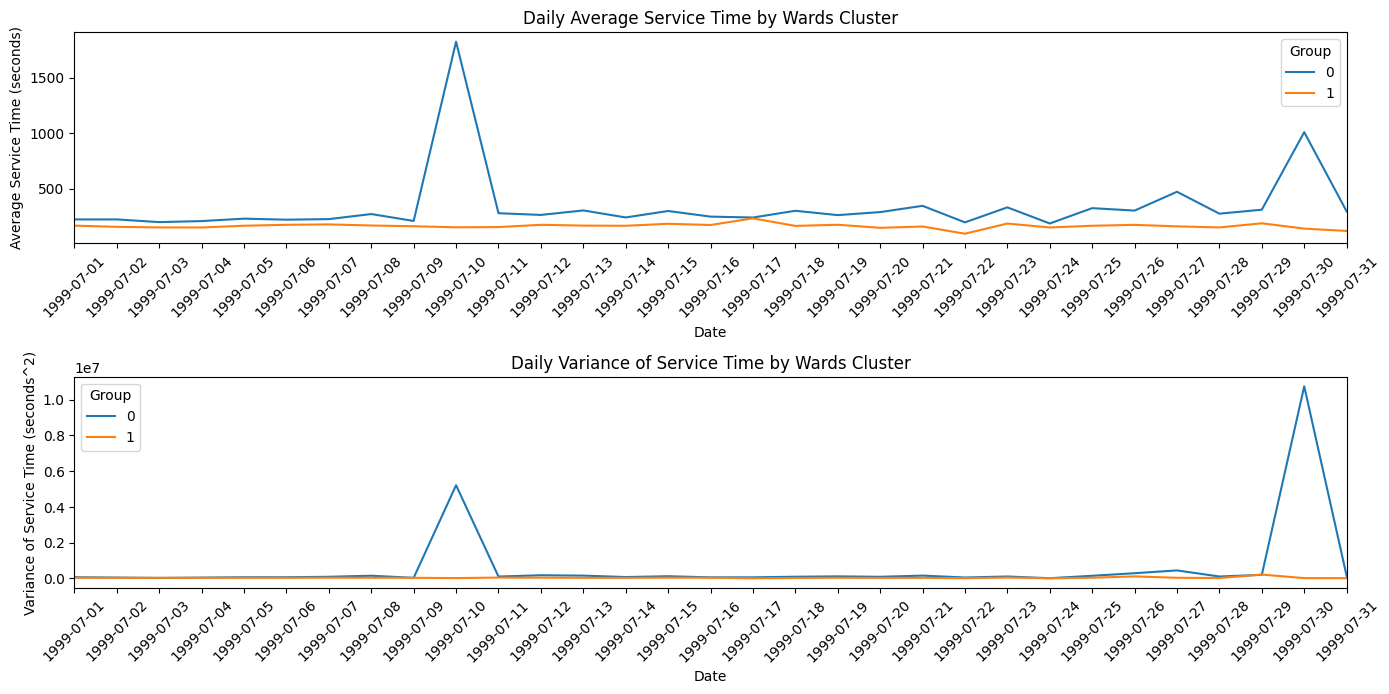

In [474]:
# Plot the average and variance as time series
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
ax1 = plt.gca()
mean_pivot.plot(ax=ax1)
plt.title('Daily Average Service Time by Wards Cluster')
plt.xlabel('Date')
plt.ylabel('Average Service Time (seconds)')
plt.legend(title='Group')
# Force all dates to appear as x-ticks
ax1.set_xticks(mean_pivot.index)
ax1.set_xticklabels([date.strftime('%Y-%m-%d') for date in mean_pivot.index], rotation=45)

plt.subplot(2, 1, 2)
ax2 = plt.gca()
var_pivot.plot(ax=ax2)
plt.title('Daily Variance of Service Time by Wards Cluster')
plt.xlabel('Date')
plt.ylabel('Variance of Service Time (seconds^2)')
plt.legend(title='Group')
plt.tight_layout()
# Force all dates to appear as x-ticks
ax2.set_xticks(var_pivot.index)
ax2.set_xticklabels([date.strftime('%Y-%m-%d') for date in var_pivot.index], rotation=45)

plt.show()

From the ward clustering method we see how the spike in one particular date still happens, this is because of the outlier

In [478]:
# Display mean service time for each grouping (group, group_2, cluster)

# Display mean service time for each grouping (group, group_2, cluster)
display(mean_ser_time.groupby('group')[['SIMPLE', 'COMPLEX']].mean())
display(mean_ser_time.groupby('group_2')[['SIMPLE', 'COMPLEX']].mean())
display(mean_ser_time.groupby('cluster')[['SIMPLE', 'COMPLEX']].mean())

type_group,SIMPLE,COMPLEX
group,,
1,166.756382,343.473916
2,202.161648,242.164357


type_group,SIMPLE,COMPLEX
group_2,,
1,156.621385,270.845696
2,213.179047,258.464185


type_group,SIMPLE,COMPLEX
cluster,,
0,249.565573,408.144003
1,169.440605,193.853217


### Let's finalise and decide to use group_2 to proceed

In [479]:
# Finalise dataframe, exclude the group and cluster columns

cc_final_df = cc_type_df.copy()
cc_final_df = cc_final_df.drop(columns=['group', 'cluster'])

cc_final_df.head()

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,type_group,group_2
2,41888,PS,1999-07-01,1999-07-01 07:30:27,1999-07-01 07:30:35,8,0:00:00,0:00:00,0,AGENT,1999-07-01 07:30:35,1999-07-01 07:34:16,221,MORIAH,Thursday,SIMPLE,1
3,41889,PS,1999-07-01,1999-07-01 07:49:32,1999-07-01 07:49:37,5,7:49:37,7:50:27,50,AGENT,1999-07-01 07:50:26,1999-07-01 07:51:48,82,ANAT,Thursday,SIMPLE,2
4,41890,PS,1999-07-01,1999-07-01 08:03:56,1999-07-01 08:04:08,12,0:00:00,0:00:00,0,AGENT,1999-07-01 08:04:07,1999-07-01 08:05:25,78,KAZAV,Thursday,SIMPLE,1
5,41891,PS,1999-07-01,1999-07-01 08:22:12,1999-07-01 08:22:25,13,0:00:00,0:00:00,0,AGENT,1999-07-01 08:22:24,1999-07-01 08:32:12,588,YIFAT,Thursday,SIMPLE,1
6,41892,PS,1999-07-01,1999-07-01 08:32:24,1999-07-01 08:32:29,5,8:32:29,8:32:45,16,AGENT,1999-07-01 08:32:44,1999-07-01 08:33:39,55,TOVA,Thursday,SIMPLE,2


### Let's calculate the interarrival times

In [521]:
# Split dataframe to simple and complex calls df

cc_simple_df = cc_final_df[cc_final_df['type_group'] == 'SIMPLE'].copy()
cc_complex_df = cc_final_df[cc_final_df['type_group'] == 'COMPLEX'].copy()

cc_simple_df = cc_simple_df.sort_values(by='vru_entry')
cc_complex_df = cc_complex_df.sort_values(by='vru_entry')

# Calculate interarrival times
cc_simple_df['interarrival_time'] = (
    cc_simple_df.groupby('date')['vru_entry'].diff().dt.total_seconds()
    )
cc_complex_df['interarrival_time'] = (
    cc_complex_df.groupby('date')['vru_entry'].diff().dt.total_seconds()
    )

# Move columns near vru_entry
cc_simple_df = cc_simple_df[['call_id', 'type', 'date', 'vru_entry', 'interarrival_time'] + [col for col in cc_simple_df.columns if col not in ['call_id', 'type', 'date', 'vru_entry', 'interarrival_time']]]
cc_complex_df = cc_complex_df[['call_id', 'type', 'date', 'vru_entry', 'interarrival_time'] + [col for col in cc_complex_df.columns if col not in ['call_id', 'type', 'date', 'vru_entry', 'interarrival_time']]]

cc_simple_df['interarrival_time'].count(), cc_complex_df['interarrival_time'].count(), \
    cc_simple_df.head(), cc_complex_df.head()

(np.int64(25025),
 np.int64(3664),
    call_id type       date           vru_entry  interarrival_time  \
 0    36802   PS 1999-07-01 1999-07-01 07:02:02                NaN   
 1    29648   NW 1999-07-01 1999-07-01 07:02:06                4.0   
 2    43009   NW 1999-07-01 1999-07-01 07:04:39              153.0   
 3    42243   PS 1999-07-01 1999-07-01 07:07:42              183.0   
 4    11120   PS 1999-07-01 1999-07-01 07:07:55               13.0   
 
              vru_exit  vru_time  q_start   q_exit  q_time outcome  \
 0 1999-07-01 07:02:11         9  0:00:00  0:00:00       0   AGENT   
 1 1999-07-01 07:02:15         9  7:02:15  7:03:17      62   AGENT   
 2 1999-07-01 07:04:48         9  7:04:48  7:06:52     124   AGENT   
 3 1999-07-01 07:07:52        10  0:00:00  0:00:00       0   AGENT   
 4 1999-07-01 07:08:09        14  0:00:00  0:00:00       0   AGENT   
 
             ser_start            ser_exit  ser_time  server day_of_week  \
 0 1999-07-01 07:02:11 1999-07-01 07:02:22   

In [488]:
cc_simple_df['interarrival_time'].describe(), cc_complex_df['interarrival_time'].describe()

(count    25283.000000
 mean        57.341297
 std         70.109292
 min          0.000000
 25%         15.000000
 50%         36.000000
 75%         74.500000
 max       1671.000000
 Name: interarrival_time, dtype: float64,
 count    3701.000000
 mean      366.806539
 std       515.849746
 min         0.000000
 25%        89.000000
 50%       211.000000
 75%       447.000000
 max      6531.000000
 Name: interarrival_time, dtype: float64)

In [490]:
# Check top 10 largest interarrival times
cc_simple_df.nlargest(10, 'interarrival_time')

,call_id,type,date,vru_entry,interarrival_time,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,type_group,group_2
881,42782,PS,1999-07-15,1999-07-15 18:53:01,1671.0,1999-07-15 18:53:15,14,0:00:00,0:00:00,0,AGENT,1999-07-15 18:53:14,1999-07-15 19:01:28,494,AVNI,Thursday,SIMPLE,2
864,42765,PS,1999-07-15,1999-07-15 16:26:34,1444.0,1999-07-15 16:27:00,26,0:00:00,0:00:00,0,AGENT,1999-07-15 16:26:59,1999-07-15 16:28:10,71,AVNI,Thursday,SIMPLE,2
2428,38395,PS,1999-07-18,1999-07-18 10:32:32,1160.0,1999-07-18 10:32:43,11,0:00:00,0:00:00,0,AGENT,1999-07-18 10:32:41,1999-07-18 10:33:12,31,AVI,Sunday,SIMPLE,1
21767,43145,PS,1999-07-22,1999-07-22 14:36:08,1010.0,1999-07-22 14:36:14,6,14:36:14,14:36:37,23,AGENT,1999-07-22 14:36:35,1999-07-22 14:39:09,154,VICKY,Thursday,SIMPLE,2
901,42803,PS,1999-07-16,1999-07-16 07:30:04,964.0,1999-07-16 07:30:17,13,0:00:00,0:00:00,0,AGENT,1999-07-16 07:30:16,1999-07-16 07:31:54,98,TOVA,Friday,SIMPLE,2
23365,45496,PS,1999-07-22,1999-07-22 14:19:18,961.0,1999-07-22 14:19:27,9,0:00:00,0:00:00,0,AGENT,1999-07-22 14:19:26,1999-07-22 14:20:06,40,VICKY,Thursday,SIMPLE,2
36310,23261,PS,1999-07-21,1999-07-21 21:00:24,952.0,1999-07-21 21:00:37,13,0:00:00,0:00:00,0,AGENT,1999-07-21 21:00:36,1999-07-21 21:03:05,149,SHARON,Wednesday,SIMPLE,1
969,42871,PS,1999-07-18,1999-07-18 10:04:01,934.0,1999-07-18 10:04:11,10,0:00:00,0:00:00,0,AGENT,1999-07-18 10:04:10,1999-07-18 10:04:22,12,AVNI,Sunday,SIMPLE,2
34692,23775,PS,1999-07-23,1999-07-23 14:22:53,909.0,1999-07-23 14:23:04,11,0:00:00,0:00:00,0,AGENT,1999-07-23 14:23:04,1999-07-23 14:23:24,20,DORIT,Friday,SIMPLE,2
14877,22077,NW,1999-07-22,1999-07-22 07:59:23,895.0,1999-07-22 07:59:41,18,0:00:00,0:00:00,0,AGENT,1999-07-22 07:59:40,1999-07-22 08:02:05,145,AVI,Thursday,SIMPLE,1


In [491]:
cc_complex_df.nlargest(10, 'interarrival_time')

,call_id,type,date,vru_entry,interarrival_time,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,type_group,group_2
15374,6343,IN,1999-07-18,1999-07-18 22:21:47,6531.0,1999-07-18 22:22:06,19,0:00:00,0:00:00,0,AGENT,1999-07-18 22:22:05,1999-07-18 22:24:18,133,BENSION,Sunday,COMPLEX,1
38651,7527,IN,1999-07-22,1999-07-22 15:19:15,5887.0,1999-07-22 15:19:31,16,0:00:00,0:00:00,0,AGENT,1999-07-22 15:19:30,1999-07-22 15:21:10,100,BASCH,Thursday,COMPLEX,2
14064,21245,NE,1999-07-05,1999-07-05 20:45:10,5688.0,1999-07-05 20:45:21,11,0:00:00,0:00:00,0,AGENT,1999-07-05 20:45:21,1999-07-05 20:48:16,175,AVI,Monday,COMPLEX,1
38654,7530,IN,1999-07-22,1999-07-22 16:51:34,5539.0,1999-07-22 16:51:50,16,0:00:00,0:00:00,0,AGENT,1999-07-22 16:51:49,1999-07-22 16:56:13,264,DARMON,Thursday,COMPLEX,2
27023,6570,NE,1999-07-21,1999-07-21 21:15:51,5445.0,1999-07-21 21:16:04,13,0:00:00,0:00:00,0,AGENT,1999-07-21 21:16:04,1999-07-21 21:16:53,49,MORIAH,Wednesday,COMPLEX,1
29038,7298,NE,1999-07-30,1999-07-30 08:38:16,5163.0,1999-07-30 08:38:27,11,0:00:00,0:00:00,0,AGENT,1999-07-30 08:38:26,1999-07-30 08:39:07,41,NAAMA,Friday,COMPLEX,2
8077,43888,NE,1999-07-15,1999-07-15 21:06:17,5023.0,1999-07-15 21:06:22,5,21:06:22,21:08:24,122,AGENT,1999-07-15 21:08:23,1999-07-15 21:08:24,1,AVI,Thursday,COMPLEX,1
9350,36906,PE,1999-07-02,1999-07-02 14:00:49,4392.0,1999-07-02 14:00:59,10,0:00:00,0:00:00,0,AGENT,1999-07-02 14:00:58,1999-07-02 14:10:19,561,YITZ,Friday,COMPLEX,1
29559,42342,NE,1999-07-05,1999-07-05 23:56:19,4160.0,1999-07-05 23:56:32,13,0:00:00,0:00:00,0,AGENT,1999-07-05 23:56:31,1999-07-05 23:57:30,59,AVI,Monday,COMPLEX,1
7818,43624,NE,1999-07-09,1999-07-09 14:00:12,4142.0,1999-07-09 14:00:20,8,0:00:00,0:00:00,0,AGENT,1999-07-09 14:00:20,1999-07-09 14:00:21,1,MORIAH,Friday,COMPLEX,1


### I guess its normal, given how small the complex call samples.

In [495]:
# Check the 0 values in interarrival times
cc_simple_df[cc_simple_df['interarrival_time'] == 0]['interarrival_time'].count(), cc_complex_df[cc_complex_df['interarrival_time'] == 0]['interarrival_time'].count() 

(np.int64(227), np.int64(6))

### Let's remove the records with 0 interarrivals

In [496]:
# Remove rows with zero interarrival times
cc_simple_df = cc_simple_df[cc_simple_df['interarrival_time'] > 0]
cc_complex_df = cc_complex_df[cc_complex_df['interarrival_time'] > 0]

cc_simple_df['interarrival_time'].describe(), cc_complex_df['interarrival_time'].describe()

(count    25056.000000
 mean        57.860792
 std         70.212437
 min          1.000000
 25%         15.000000
 50%         37.000000
 75%         75.000000
 max       1671.000000
 Name: interarrival_time, dtype: float64,
 count    3695.000000
 mean      367.402165
 std       516.056472
 min         1.000000
 25%        89.000000
 50%       211.000000
 75%       447.500000
 max      6531.000000
 Name: interarrival_time, dtype: float64)

In [501]:
# Combine the two dataframes back into one
cc_final_df = pd.concat([cc_simple_df, cc_complex_df], ignore_index=True)

cc_final_df.head()

,call_id,type,date,vru_entry,interarrival_time,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,type_group,group_2
0,36802,PS,1999-07-01,1999-07-01 07:02:02,88.0,1999-07-01 07:02:11,9,0:00:00,0:00:00,0,AGENT,1999-07-01 07:02:11,1999-07-01 07:02:22,11,TOVA,Thursday,SIMPLE,2
1,29648,NW,1999-07-01,1999-07-01 07:02:06,4.0,1999-07-01 07:02:15,9,7:02:15,7:03:17,62,AGENT,1999-07-01 07:03:16,1999-07-01 07:03:18,2,MORIAH,Thursday,SIMPLE,1
2,43009,NW,1999-07-01,1999-07-01 07:04:39,153.0,1999-07-01 07:04:48,9,7:04:48,7:06:52,124,AGENT,1999-07-01 07:06:51,1999-07-01 07:07:47,56,MORIAH,Thursday,SIMPLE,1
3,42243,PS,1999-07-01,1999-07-01 07:07:42,183.0,1999-07-01 07:07:52,10,0:00:00,0:00:00,0,AGENT,1999-07-01 07:07:51,1999-07-01 07:12:31,280,TOVA,Thursday,SIMPLE,2
4,11120,PS,1999-07-01,1999-07-01 07:07:55,13.0,1999-07-01 07:08:09,14,0:00:00,0:00:00,0,AGENT,1999-07-01 07:08:08,1999-07-01 07:11:42,214,ANAT,Thursday,SIMPLE,2


### Finally, perform KS test to get all our parameters

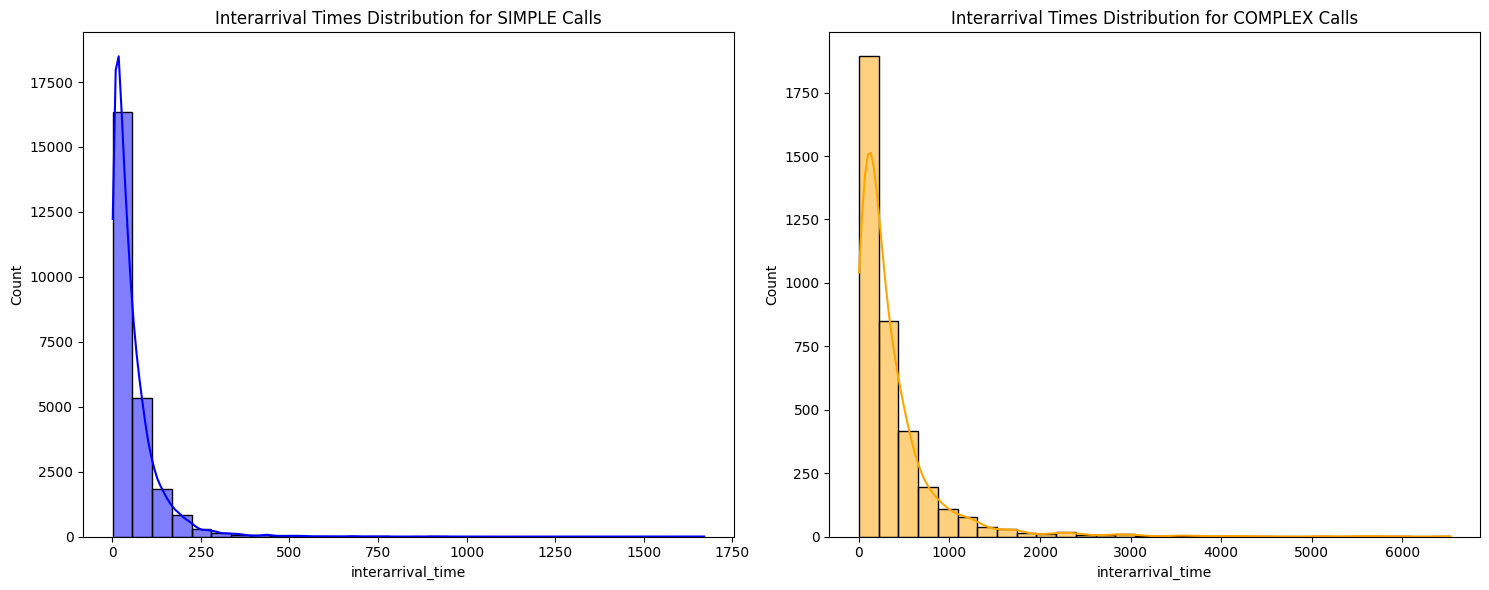

In [505]:
# Plot interarrival times distribution for both call types
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.histplot(cc_simple_df['interarrival_time'], bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Interarrival Times Distribution for SIMPLE Calls')
sns.histplot(cc_complex_df['interarrival_time'], bins=30, kde=True, ax=axes[1], color='orange')
axes[1].set_title('Interarrival Times Distribution for COMPLEX Calls')
plt.tight_layout()
plt.show()

In [502]:
# Remove NA values in interarrival times
cc_simple_df = cc_simple_df.dropna(subset=['interarrival_time'])
cc_complex_df = cc_complex_df.dropna(subset=['interarrival_time'])

# KS on interarrival times
result_simple = ks_test_distributions_df(cc_simple_df['interarrival_time'])
result_complex = ks_test_distributions_df(cc_complex_df['interarrival_time'])

print("Simple Calls Interarrival Times Distribution Test Results:")
print(result_simple)
print("\nComplex Calls Interarrival Times Distribution Test Results:")
print(result_complex)

Simple Calls Interarrival Times Distribution Test Results:
             D-statistic       p-value  reject_null   best_fit
exponential     0.658844  0.000000e+00         True  lognormal
gamma           0.946032  0.000000e+00         True  lognormal
lognormal       0.037078  2.303520e-30         True  lognormal

Complex Calls Interarrival Times Distribution Test Results:
             D-statistic   p-value  reject_null   best_fit
exponential     0.685792  0.000000         True  lognormal
gamma           0.991004  0.000000         True  lognormal
lognormal       0.025393  0.016754         True  lognormal


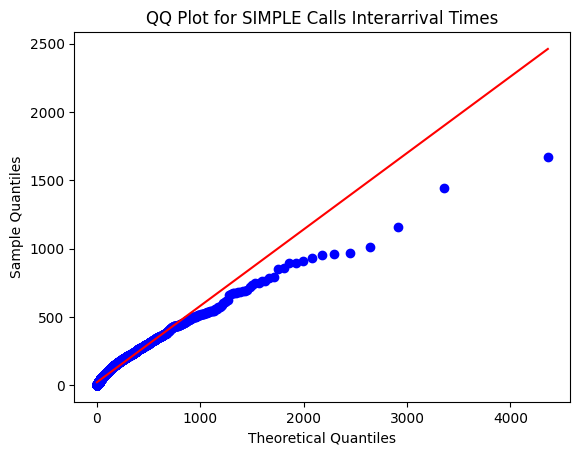

In [508]:
# QQ plots for interarrival times
qq_plot_lognorm(cc_simple_df['interarrival_time'], 'QQ Plot for SIMPLE Calls Interarrival Times')

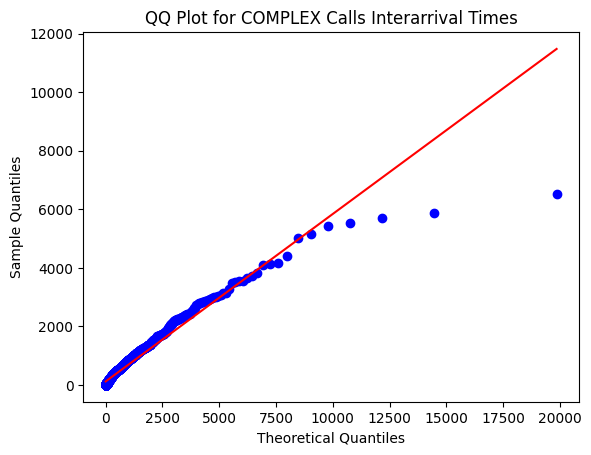

In [509]:
qq_plot_lognorm(cc_complex_df['interarrival_time'], 'QQ Plot for COMPLEX Calls Interarrival Times')

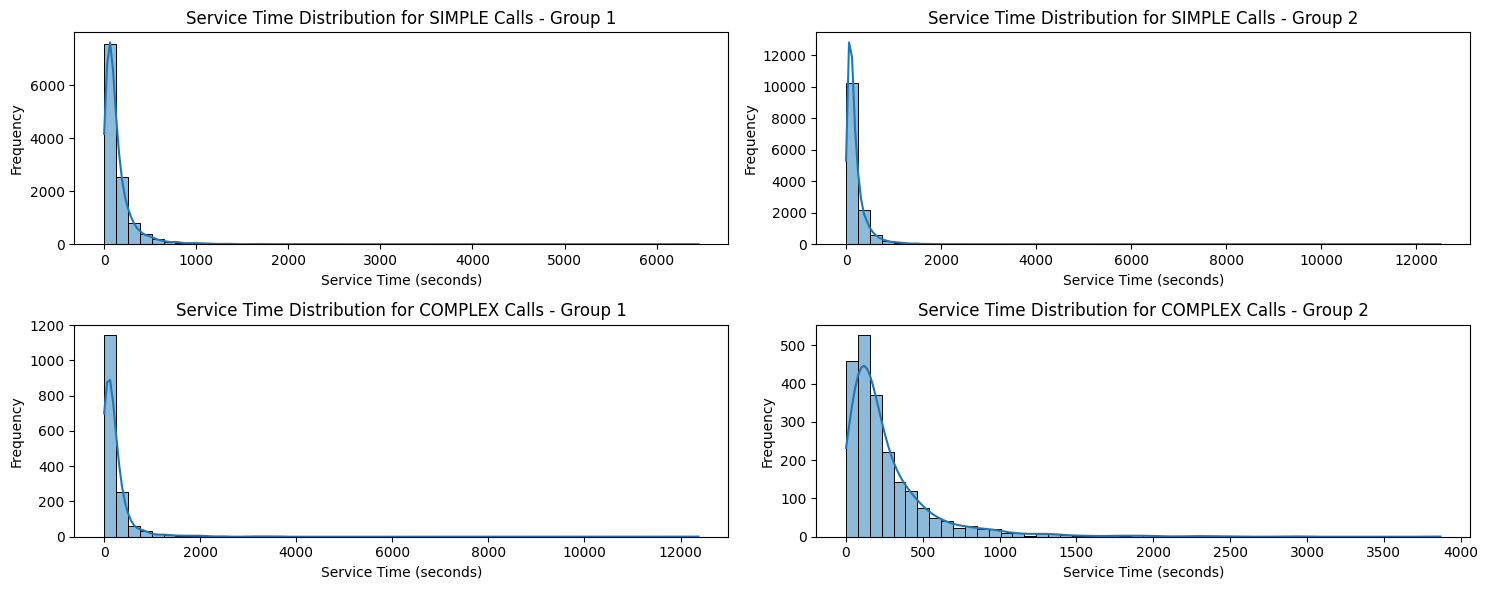

In [507]:
# Plot service time distributions for both call types and server groups
ct = ['SIMPLE', 'COMPLEX']
agents = ['1', '2']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
for i, call_type in enumerate(ct):
    for j, agent in enumerate(agents):
        ax = axes[i, j]
        sns.histplot(cc_final_df[(cc_final_df['type_group'] == call_type) & (cc_final_df['group_2'] == agent)]['ser_time'], bins=50, kde=True, ax=ax)
        ax.set_title(f'Service Time Distribution for {call_type} Calls - Group {agent}')
        ax.set_xlabel('Service Time (seconds)')
        ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()


In [503]:
result_server_group = {}
for (group_2, type_group), group in cc_final_df.groupby(['group_2', 'type_group']):
    ser_time = group['ser_time']
    result_server_group[(group_2, type_group)] = ks_test_distributions_df(ser_time)
    print(f"{group_2} - {type_group}:\n", result_server_group[(group_2, type_group)], "\n")

1 - COMPLEX:
              D-statistic       p-value  reject_null   best_fit
exponential     0.711676  0.000000e+00         True  lognormal
gamma           0.971721  0.000000e+00         True  lognormal
lognormal       0.072278  2.073844e-07         True  lognormal 

1 - SIMPLE:
              D-statistic       p-value  reject_null   best_fit
exponential     0.689236  0.000000e+00         True  lognormal
gamma           0.975555  0.000000e+00         True  lognormal
lognormal       0.044194  3.061383e-20         True  lognormal 

2 - COMPLEX:
              D-statistic       p-value  reject_null   best_fit
exponential     0.682239  0.000000e+00         True  lognormal
gamma           0.058582  6.840656e-07         True  lognormal
lognormal       0.020628  3.121107e-01        False  lognormal 

2 - SIMPLE:
              D-statistic       p-value  reject_null   best_fit
exponential     0.685465  0.000000e+00         True  lognormal
gamma           0.998330  0.000000e+00         True  logno

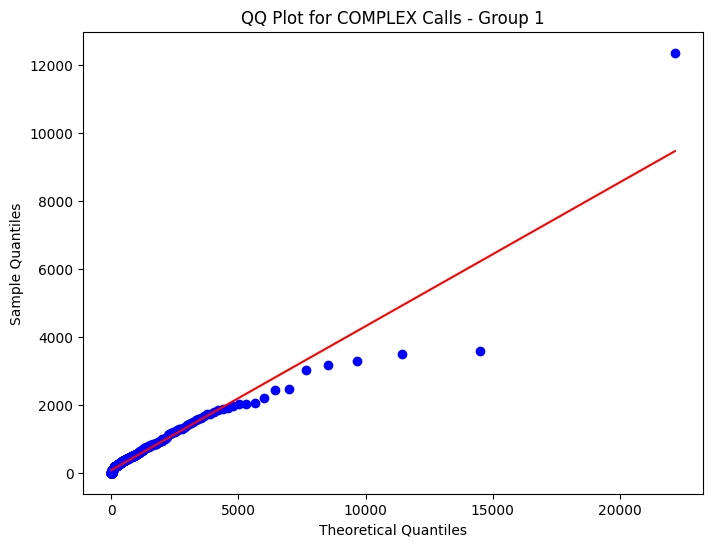

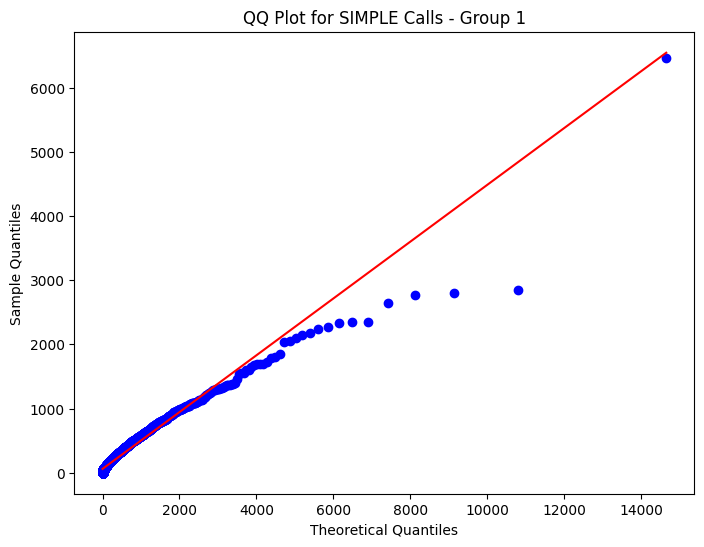

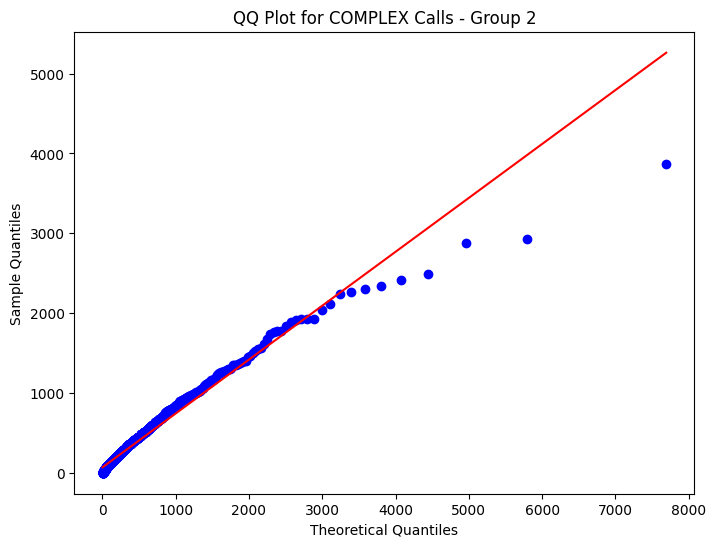

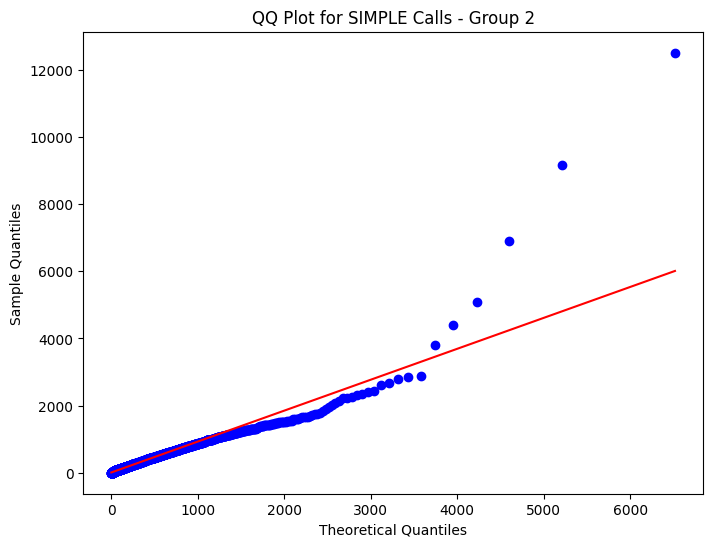

In [511]:
# Plot the service time QQ plots
for (group_2, type_group), group in cc_final_df.groupby(['group_2', 'type_group']):
    plt.figure(figsize=(8, 6))
    qq_plot_lognorm(group['ser_time'], f'QQ Plot for {type_group} Calls - Group {group_2}')
    plt.show()

In [512]:
# Collect the best fitting parameters for each results
best_fit_service_params = {}
for (group_2, type_group), df in result_server_group.items():
    best_fit = df['best_fit'].iloc[0]
    if best_fit == 'exponential':
        params = (df.loc['exponential', 'D-statistic'],)
    elif best_fit == 'gamma':
        params = stats.gamma.fit(cc_final_df[(cc_final_df['group_2'] == group_2) & (cc_final_df['type_group'] == type_group)]['ser_time'])
    elif best_fit == 'lognormal':
        params = stats.lognorm.fit(cc_final_df[(cc_final_df['group_2'] == group_2) & (cc_final_df['type_group'] == type_group)]['ser_time'])
    else:
        params = None
    best_fit_service_params[(group_2, type_group)] = params
    
print("Best fitting service time distribution parameters for each group and call type:")
for (group_2, type_group), params in best_fit_service_params.items():
    print(f"{group_2} - {type_group}: {params}")

Best fitting service time distribution parameters for each group and call type:
1 - COMPLEX: (np.float64(1.204511467147714), -9.755593679326038, np.float64(119.24909591789675))
1 - SIMPLE: (np.float64(0.9261161935026054), -13.961890656808079, np.float64(104.50676710322796))
2 - COMPLEX: (np.float64(0.9070418221009697), -17.41269162958764, np.float64(192.3101172153293))
2 - SIMPLE: (np.float64(0.8551150573776538), -12.157121613393747, np.float64(146.23142143889223))


In [513]:
shape_simple, loc_simple, scale_simple = stats.lognorm.fit(cc_simple_df['ser_time'])
shape_complex, loc_complex, scale_complex = stats.lognorm.fit(cc_complex_df['ser_time'])

In [517]:
# Place the params in a dataframe
best_fit_params_df = pd.DataFrame.from_dict(best_fit_service_params, orient='index', columns=['shape', 'loc', 'scale'])

best_fit_params_df = best_fit_params_df.reset_index().rename(columns={'index': 'param_name'})

# Add the shape, loc, and scale for simple and complex calls
best_fit_interarrival_df = pd.DataFrame([
    {'param_name': 'SIMPLE', 'shape': shape_simple, 'loc': loc_simple, 'scale': scale_simple},
    {'param_name': 'COMPLEX', 'shape': shape_complex, 'loc': loc_complex, 'scale': scale_complex}
])

# Concatenate the best fit parameters for service times and interarrival times
best_fit_params_df = pd.concat([best_fit_params_df, best_fit_interarrival_df], ignore_index=True)

best_fit_params_df


,param_name,shape,loc,scale
0,"(1, COMPLEX)",1.204511,-9.755594,119.249096
1,"(1, SIMPLE)",0.926116,-13.961891,104.506767
2,"(2, COMPLEX)",0.907042,-17.412692,192.310117
3,"(2, SIMPLE)",0.855115,-12.157122,146.231421
4,SIMPLE,0.881651,-15.594575,128.663410
5,COMPLEX,0.987725,-18.410834,167.117964


In [520]:
# Calculate mu and sigma for lognormal distribution from the best fitting parameters
lognorm_params = {}
for (group_2, type_group), params in best_fit_service_params.items():
    if isinstance(params, tuple) and len(params) == 3:  # lognormal parameters
        shape, loc, scale = params
        mu = np.log(scale)
        sigma = shape
        lognorm_params[(group_2, type_group)] = (mu, sigma)
    else:
        lognorm_params[(group_2, type_group)] = None
        
lognorm_params_df = pd.DataFrame.from_dict(lognorm_params, orient='index', columns=['mu', 'sigma'])

lognorm_params_df

,mu,sigma
"(1, COMPLEX)",4.781215,1.204511
"(1, SIMPLE)",4.649252,0.926116
"(2, COMPLEX)",5.259109,0.907042
"(2, SIMPLE)",4.985190,0.855115
